# Pareto/NBD Model
The Pareto/Negative-Binomial Distribution model was the first Buy-Till-You-Die (BTYD) model for estimating non-contractual customer activity over a continuous time period. First introduced by Schmittlein, et. al. in 1987 and developed further by Bruce Hardie and Peter Fader, it is frequently used as a benchmark in CLV research due to its robust performance and wide range of functionality. For detailed derivations of this model please refer to
["A Note on Deriving the Pareto/NBD Model and Related Expressions."](https://www.brucehardie.com/notes/009/pareto_nbd_derivations_2005-11-05.pdf)

In this notebook we will use Bayesian inference to fit a Pareto/NBD model in PyMC-Marketing, and compare results with the frequentist [`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) library (no longer maintained). We will also demonstrate the predictive functionality of this model, along with an example for time-invariant covariates.

## Setup Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sb
import xarray as xr
from fastprogress.fastprogress import progress_bar
from lifetimes import ParetoNBDFitter

from pymc_marketing import clv

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Load Data

In this notebook we will be using the CDNOW sample dataset, a popular benchmarking dataset in CLV and BTYD modeling research. Refer [here](https://www.brucehardie.com/notes/026/) for more information about the dataset.

In [2]:
url_cdnow = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/cdnow_transactions.csv"

raw_data = pd.read_csv(url_cdnow)

raw_data.info()
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6919 entries, 0 to 6918
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   _id         6919 non-null   int64  
 1   id          6919 non-null   int64  
 2   date        6919 non-null   int64  
 3   cds_bought  6919 non-null   int64  
 4   spent       6919 non-null   float64
dtypes: float64(1), int64(4)
memory usage: 270.4 KB


,_id,id,date,cds_bought,spent
0,4,1,19970101,2,29.33
1,4,1,19970118,2,29.73
2,4,1,19970802,1,14.96
3,4,1,19971212,2,26.48
4,21,2,19970101,3,63.34


The only requirements for modeling spending behaviour with `ParetoNBDModel` are a customer identifier column, and a datetime column for each purchase. The number of CDs purchased and money spent per transaction could also be useful covariates, so we'll keep them in mind for later.

It is common for customer transaction databases to also contain returns, discount values, etc., so let's do a quick validation check:

In [3]:
raw_data.describe()

,_id,id,date,cds_bought,spent
count,6919.000000,6919.000000,6.919000e+03,6919.000000,6919.000000
mean,11682.515826,1175.724816,1.997217e+07,2.381703,35.278500
std,6833.386793,679.426450,3.744182e+03,2.218380,34.074377
min,4.000000,1.000000,1.997010e+07,1.000000,0.000000
25%,5525.000000,570.500000,1.997022e+07,1.000000,14.490000
50%,11749.000000,1193.000000,1.997042e+07,2.000000,25.990000
75%,17717.000000,1766.000000,1.997103e+07,3.000000,42.970000
max,23569.000000,2357.000000,1.998063e+07,40.000000,506.970000


Note there were some transactions with spend values of 0! Perhaps these were returns or promotional giveaways. Instances such as this are not true purchasing activities, and should be excluded from modeling.

In [4]:
raw_data = raw_data[raw_data["spent"] > 0]

Use the `rfm_summary` utility to aggregate data for modeling:

In [5]:
rfm_data = clv.rfm_summary(
    raw_data,
    customer_id_col="id",
    datetime_col="date",
    datetime_format="%Y%m%d",
    time_unit="W",
)

rfm_data.info()
rfm_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2349 entries, 0 to 2348
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  2349 non-null   int64  
 1   frequency    2349 non-null   float64
 2   recency      2349 non-null   float64
 3   T            2349 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 73.5 KB


,customer_id,frequency,recency,T
0,1,3.0,49.0,78.0
1,2,1.0,2.0,78.0
2,3,0.0,0.0,78.0
3,4,0.0,0.0,78.0
4,5,0.0,0.0,78.0


Recall the data aggregation definitions from the [CLV Quickstart](https://www.pymc-marketing.io/en/stable/notebooks/clv/clv_quickstart.html):

- `customer_id` is an index of a unique identifiers for each customer.
- `frequency` is the number of repeat purchases that a customer has made (i.e., total number of purchases minus one).
- `recency` indicates the time period when a customer made their most recent purchase. If a customer has only made 1 purchase, recency is 0.
- `T` is a customer's "age", or the number of time periods since their first purchase.

## Model Definition
The Pareto/NBD model is based on the following assumptions for each customer:
1. Customers are active for an unobserved period of time, then become permanently inactive.
   
#### Purchasing Process

2. While active, the the number of transactions made by a customer follows a Poisson process with transaction rate $\lambda$:
   
   $$P(X(t)=x|\lambda) = \frac{(\lambda t)^{x}e^{-\lambda t}}{x!}, x=0,1,2,...$$
   
   This is equivalent to assuming time between transactions is exponentially distributed with transaction rate $\lambda$:
   
   $$f(t_{j}-t_{j-1}| \lambda) = \lambda e^{-\lambda (t_{j} - t_{j - 1})}, \quad t_{j} \geq t_{j - 1} \geq 0$$
   
   Where $t$ is the time period of the $j$th purchase.
3. Heterogeneity in $\lambda$ follows a Gamma distribution with shape parameter $r$ and scale parameter $\alpha$:

    $$g(\lambda|r, \alpha) = \frac{\alpha^{r}\lambda^{r - 1}e^{-\lambda \alpha}}{\Gamma(r)}$$
#### Dropout Process
4. The duration of a customer's unobserved active lifetime is exponentially distributed with dropout rate $\mu$.

5. Heterogeneity in $\mu$ also follows a Gamma distribution with shape parameter $s$ and scale parameter $\beta$:

    $$g(\mu|s, \beta) = \frac{\beta^{s}\mu^{s - 1}e^{-\mu \beta}}{\Gamma(s)}$$
   
6. Transaction rate $\lambda$ and time until dropout $\mu$ vary independently for each customer.

If we take the expectation across the distributions of $\lambda$ and $\mu$, we can derive a likelihood function to estimate parameters $r$, $\alpha$, $s$, and $\beta$ across the customer population. For more details on the `ParetoNBD` likelihood please refer to the [docs](https://www.pymc-marketing.io/en/stable/api/generated/pymc_marketing.clv.distributions.ParetoNBD.html#pymc_marketing.clv.distributions.ParetoNBD).

## Model Fitting

### `lifetimes` Benchmark Model

Let's time travel back to July 2020 and use the old `lifetimes` library to fit a Pareto/NBD model with Maximum Likelihood Estimation (MLE). The `Nelder-Mead` optimizer from `scipy.optimize` is ran under the hood to estimate scalar values for $r$, $\alpha$, $s$, and $\beta$.

In [6]:
freq = rfm_data["frequency"].values
rec = rfm_data["recency"].values
T = rfm_data["T"].values

pnbd_lt = ParetoNBDFitter()
pnbd_lt.fit(freq, rec, T)
pnbd_lt.params_.sort_index()

alpha    15.643599
beta     13.799387
r         0.614059
s         0.446622
dtype: float64

The Bayesian equivalent of MLE is Maximum a Posteriori(MAP), in which the returned scalar values are regularized with priors during estimation.

A "Flat" prior indicates the user is agnostic, holding no prior beliefs or assumptions about the data. $r$, $\alpha$, $s$, and $\beta$ must also be positive values, so let's configure our Bayesian `ParetoNBDModel` with `HalfFlat` priors:

In [7]:
flat_config = {
    "r_prior": {"dist": "HalfFlat", "kwargs": {}},
    "alpha_prior": {"dist": "HalfFlat", "kwargs": {}},
    "s_prior": {"dist": "HalfFlat", "kwargs": {}},
    "beta_prior": {"dist": "HalfFlat", "kwargs": {}},
}

pnbd_pymc = clv.ParetoNBDModel(data=rfm_data, model_config=flat_config)

Build the model to view the choice of Priors used for modeling:

In [8]:
pnbd_pymc.build_model()  # optional step
pnbd_pymc

Pareto/NBD
            alpha ~ HalfFlat()
             beta ~ HalfFlat()
                r ~ HalfFlat()
                s ~ HalfFlat()
recency_frequency ~ ParetoNBD(r, alpha, s, beta, <constant>)

Note it is not necessary to build a model prior to modeling.

Now let's fit our `ParetoNBDModel` with MAP.

In [9]:
idata_map = pnbd_pymc.fit(fit_method="map")

Output()

For MAP fitting `pymc-marketing` uses the `L_BGFS-B` optimizer from `scipy.optimize`, a faster and more stable alternative to `Nelder-Mead`.

In [10]:
flat_fit = pnbd_pymc.fit_summary()
print(flat_fit)

alpha    15.644
beta     13.796
r         0.614
s         0.447
Name: value, dtype: float64


Model parameter estimations are equivalent between the frequentist MLE fit from `lifetimes`, and a Bayesian `pymc-marketing` model fit with flat priors. However, the CDNOW sample we're working with is quite small and comprises only 10% of the total CDNOW dataset, so it's quite likely these estimates are overfitting if we attempt to run predictions on the full dataset.

With prior distributions, we can inform model fitting with our own subjective domain knowledge, and even improve the speed of model fits. The default prior configuration for `ParetoNBDModel` works well for a variety of use cases:

In [11]:
pnbd_map = clv.ParetoNBDModel(data=rfm_data)
pnbd_map.build_model()  # required for prior predictive checks
pnbd_map

Pareto/NBD
            alpha ~ Weibull(2, 10)
             beta ~ Weibull(2, 10)
                r ~ Weibull(2, 1)
                s ~ Weibull(2, 1)
recency_frequency ~ ParetoNBD(r, alpha, s, beta, <constant>)

#### Prior and Posterior Predictive Checks
PPCs allow us to check the efficacy of our priors, and the peformance of the fitted posteriors. PPCs aren't usually an option with MAP fitted models, but here we're actually sampling from the latent $\lambda$ and $\mu$ Gamma distributions, so PPCs are possible for `ParetoNBDModel` regardless of the fit method!

Let's see how the model performs in a *prior* predictive check, where we sample from the default priors before fitting the model: 

Sampling: [alpha, beta, r, recency_frequency, s]


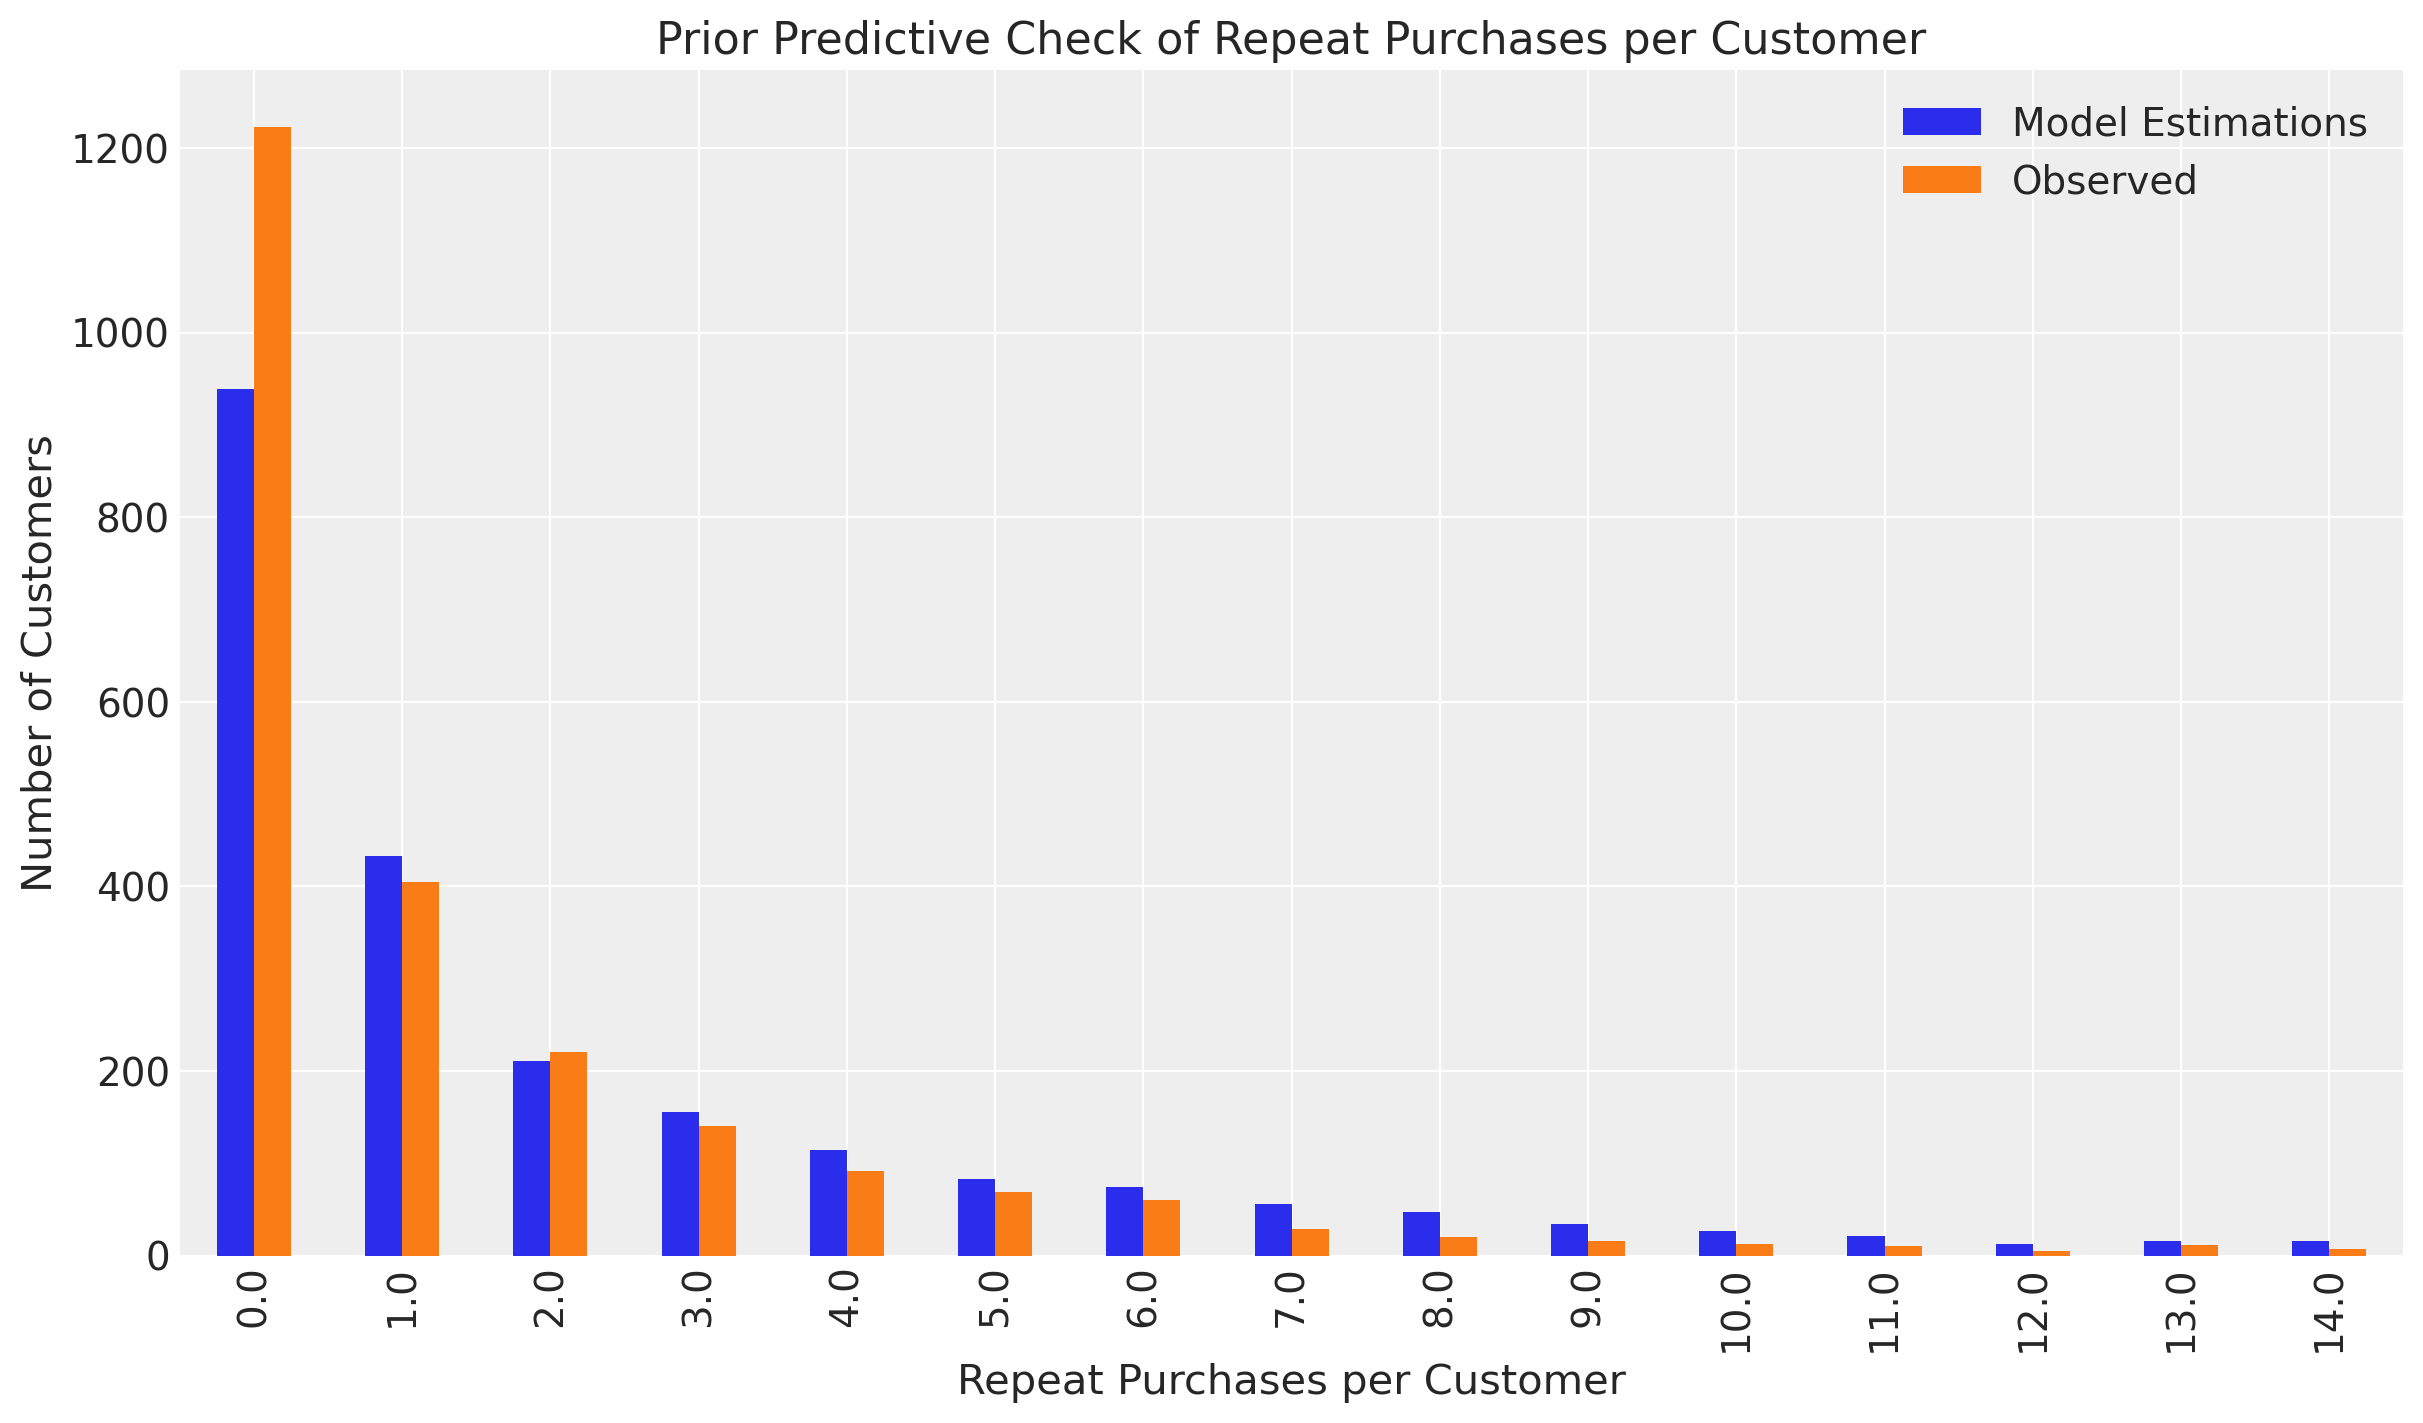

In [12]:
with pnbd_map.model:
    prior_idata = pm.sample_prior_predictive(random_seed=45, samples=1)

obs_freq = prior_idata.observed_data["recency_frequency"].sel(obs_var="frequency")
ppc_freq = prior_idata.prior_predictive["recency_frequency"].sel(obs_var="frequency")[
    0
][0]

# PPC histogram plot
pd.DataFrame(
    {
        "Model Estimations": ppc_freq.to_pandas().value_counts().sort_index(),
        "Observed": obs_freq.to_pandas().value_counts().sort_index(),
    }
).head(15).plot(
    kind="bar",
    title="Prior Predictive Check of Repeat Purchases per Customer",
    xlabel="Repeat Purchases per Customer",
    ylabel="Number of Customers",
    figsize=(12, 7),
);

/home/wdean/micromamba/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/ecdf_utils.py:144: UserWarning: Assuming variable is continuous for calibration of pointwise bands. If the variable is discrete, specify random variable sampler `rvs`.
  warnings.warn(


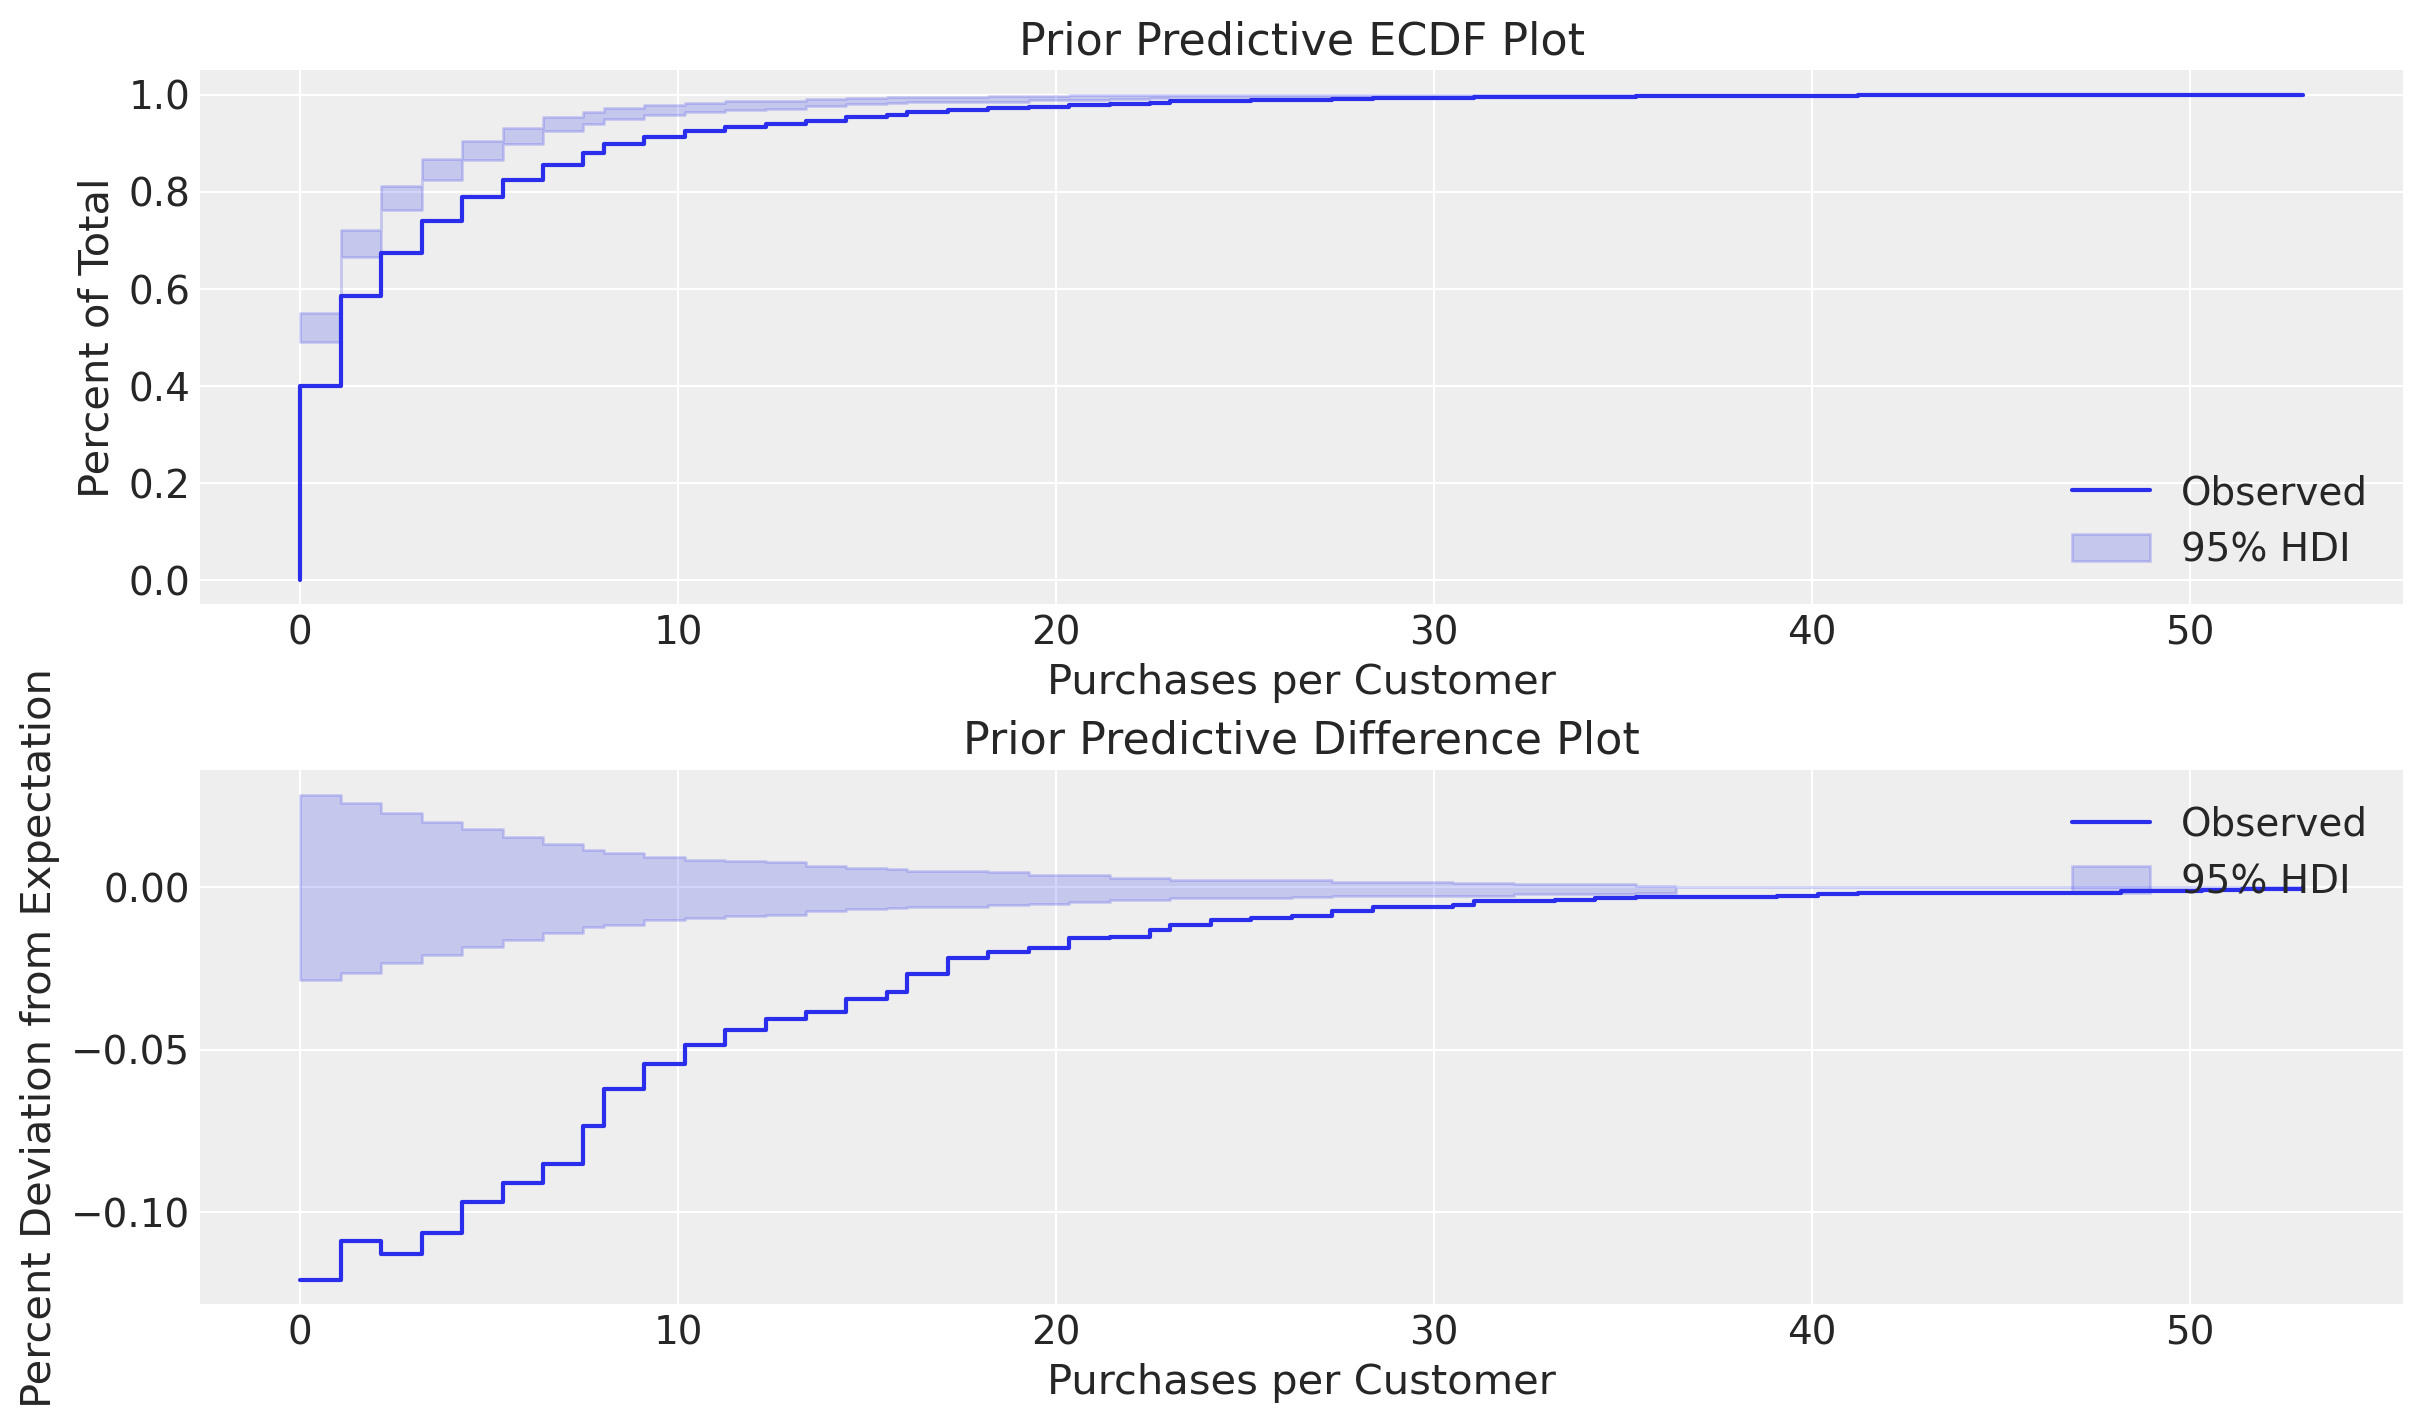

In [13]:
# create axes for each companion plot
_, axes = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 7),
)
axes = axes.flatten()

# ArviZ ECDF plot
az.plot_ecdf(
    ppc_freq,
    obs_freq,
    confidence_bands=True,
    ax=axes[0],
    fill_kwargs={"label": "95% HDI"},
    plot_kwargs={"label": "Observed"},
).set(
    title="Prior Predictive ECDF Plot",
    xlabel="Purchases per Customer",
    ylabel="Percent of Total",
)
axes[0].legend(loc="lower right")

# ArviZ ECDF Diff plot
az.plot_ecdf(
    ppc_freq,
    obs_freq,
    confidence_bands=True,
    difference=True,
    ax=axes[1],
    fill_kwargs={"label": "95% HDI"},
    plot_kwargs={"label": "Observed"},
).set(
    title="Prior Predictive Difference Plot",
    xlabel="Purchases per Customer",
    ylabel="Percent Deviation from Expectation",
)
axes[1].legend(loc="upper right");

Here the `ParetoNBDModel` is simulating customer purchases from the prior distributions to compare against the obseved data. The priors we specified look reasonable for customers who have made 1-6 purchases, but does not model single-purchase customers well. The deviations beyond the confidence intervals of the Emperical Cumulative Distribution Function (ECDF) and Difference plots indicate the importance of single purchases customers - in fact they comprise over half the CDNOW sample dataset! 

Let's fit our model and run a *posterior* predictive check for comparison:

Output()

Sampling: [recency_frequency]


Output()

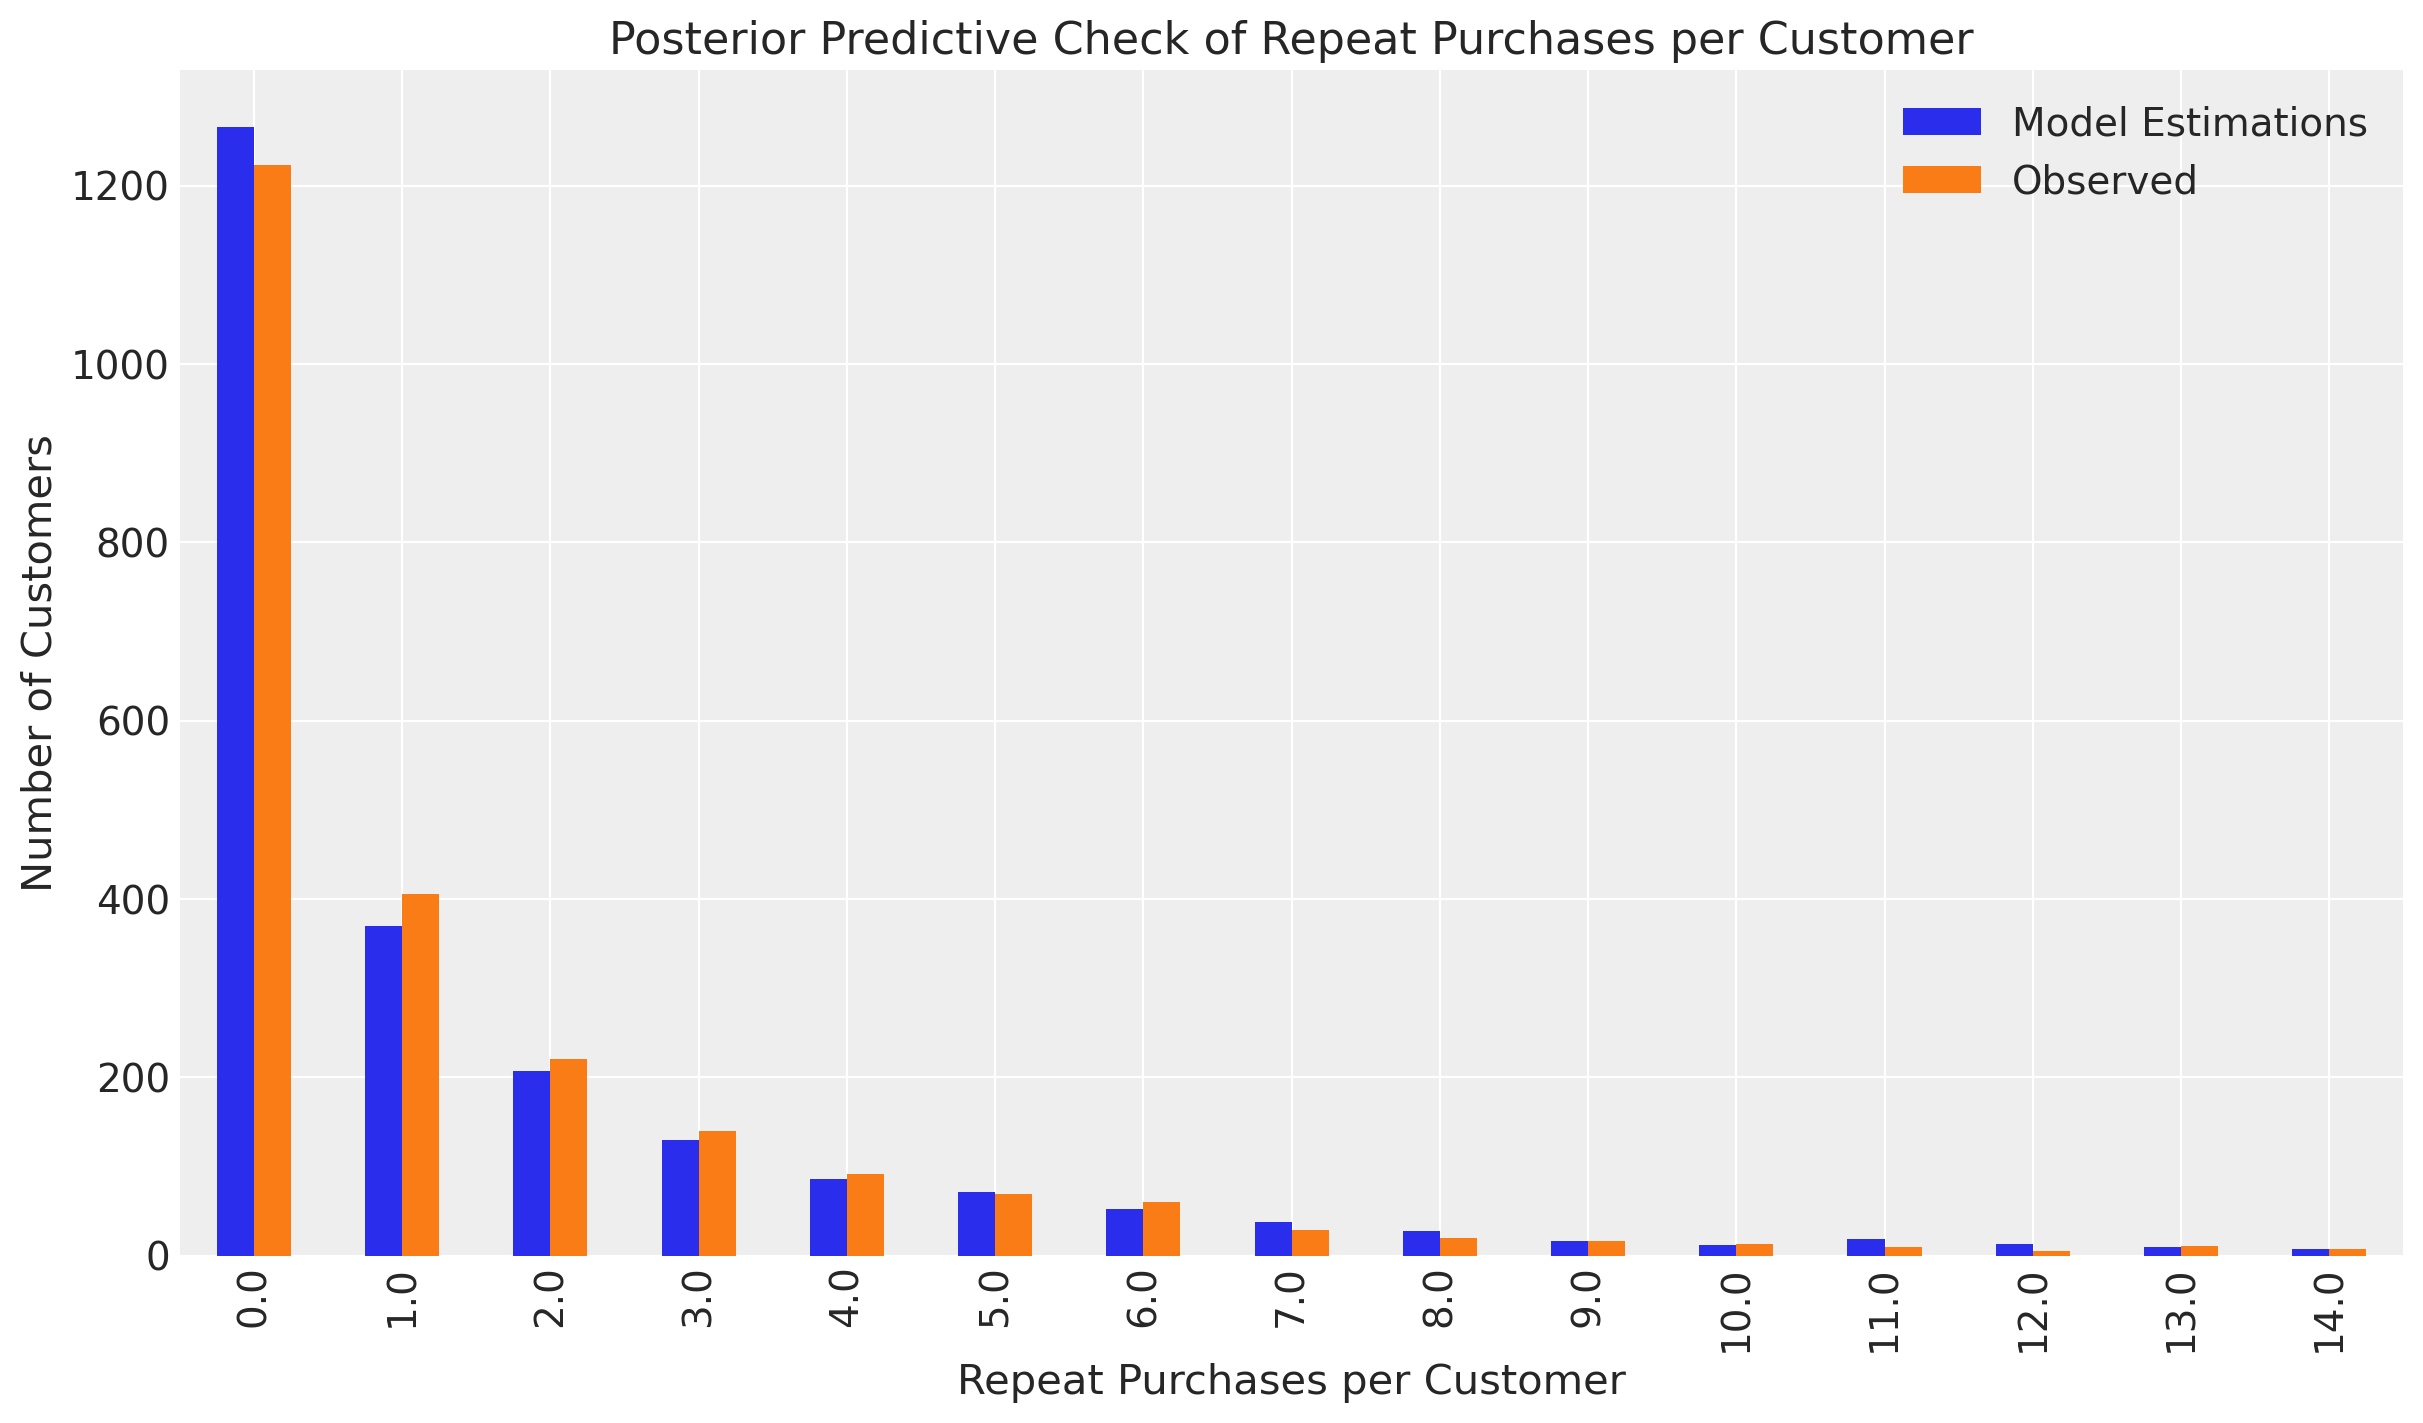

In [14]:
pnbd_map.fit()
map_fit = pnbd_map.fit_summary()  # save for plotting later

obs_freq = pnbd_map.idata.observed_data["recency_frequency"].sel(obs_var="frequency")
ppc_freq = pnbd_map.distribution_new_customer_recency_frequency(
    rfm_data,
    random_seed=42,
).sel(chain=0, draw=0, obs_var="frequency")

# PPC histogram plot
pd.DataFrame(
    {
        "Model Estimations": ppc_freq.to_pandas().value_counts().sort_index(),
        "Observed": obs_freq.to_pandas().value_counts().sort_index(),
    }
).head(15).plot(
    kind="bar",
    title="Posterior Predictive Check of Repeat Purchases per Customer",
    xlabel="Repeat Purchases per Customer",
    ylabel="Number of Customers",
    figsize=(12, 7),
);

/home/wdean/micromamba/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/stats/ecdf_utils.py:144: UserWarning: Assuming variable is continuous for calibration of pointwise bands. If the variable is discrete, specify random variable sampler `rvs`.
  warnings.warn(


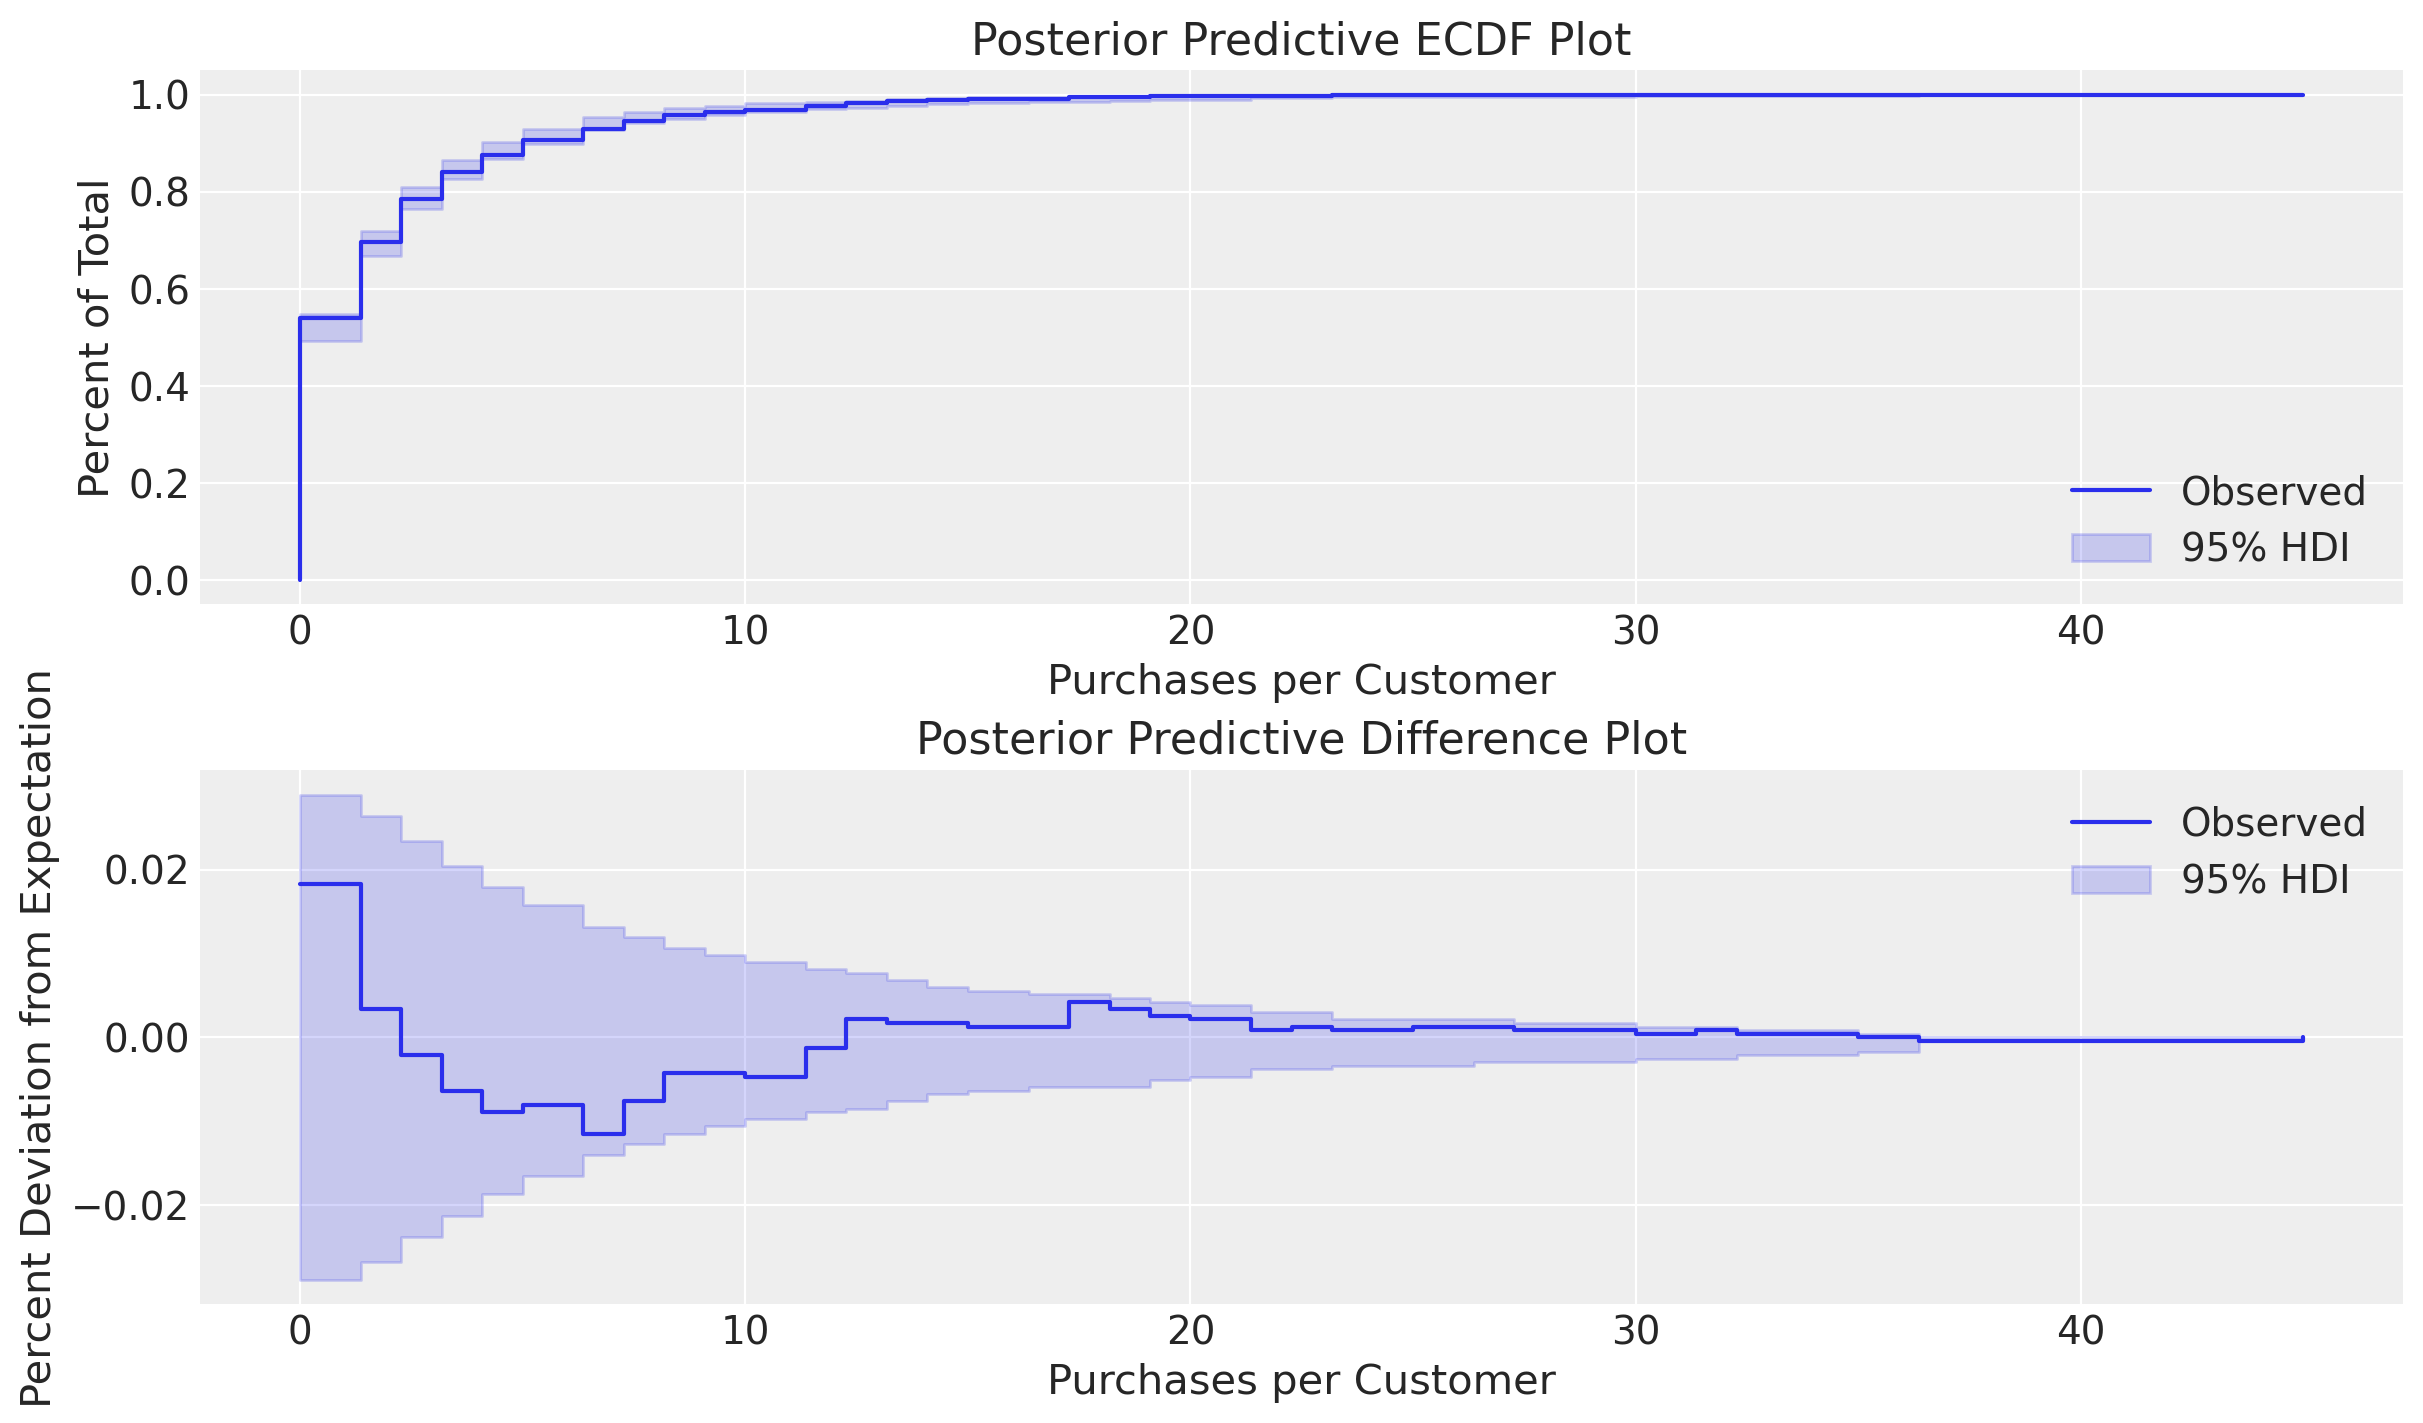

In [15]:
# create axes for each companion plot
_, axes = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 7),
)
axes = axes.flatten()

# ArviZ ECDF plot
az.plot_ecdf(
    ppc_freq,
    obs_freq,
    confidence_bands=True,
    ax=axes[0],
    fill_kwargs={"label": "95% HDI"},
    plot_kwargs={"label": "Observed"},
).set(
    title="Posterior Predictive ECDF Plot",
    xlabel="Purchases per Customer",
    ylabel="Percent of Total",
)
axes[0].legend(loc="lower right")

# ArviZ ECDF Diff plot
az.plot_ecdf(
    ppc_freq,
    obs_freq,
    confidence_bands=True,
    difference=True,
    ax=axes[1],
    fill_kwargs={"label": "95% HDI"},
    plot_kwargs={"label": "Observed"},
).set(
    title="Posterior Predictive Difference Plot",
    xlabel="Purchases per Customer",
    ylabel="Percent Deviation from Expectation",
)
axes[1].legend(loc="upper right");

Our fitted model is able to reliably simulate customer behavior!

## Full Bayesian Inference

MAP fits estimate only scalar values for $r$, $\alpha$, $s$, and $\beta$, but with full Bayesian sampling we can infer the posterior probability distributions for these parameters, illustrating uncertainty in our estimates as well as enabling prediction intervals.

NUTS is the default sampler in `pymc-marketing`, which samples from the posterior by exploring the gradients of the probability space. However, NUTS sampling with `ParetoNBDModel` can be quite slow due to the complexity of the likelihood expression. In fact, the mathematical complexity of this model is what motivated the development of the [`BetaGeoModel`](https://www.pymc-marketing.io/en/stable/notebooks/clv/bg_nbd.html) in 2005. The BG/NBD model makes some simplifying assumptions and sacrifices functionality in customer dropout estimation for better computational performance.

To save time and computational costs, it is recommended to use gradient-free methods such as `pm.DEMetropolisZ`. This often requires more samples during fitting, so if any `rhat statistic` warnings are encountered, increase the size of the `tune` and `draw` parameters until the warning no longer appears.

In [16]:
pnbd_full = clv.ParetoNBDModel(data=rfm_data)
pnbd_full.build_model()

with pnbd_full.model:
    pnbd_full.idata = pm.sample(
        step=pm.DEMetropolisZ(),
        tune=2500,
        draws=3000,
        idata_kwargs={"log_likelihood": True},
    )

/home/wdean/micromamba/envs/pymc-marketing-dev/lib/python3.10/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: Optimization Warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/home/wdean/micromamba/envs/pymc-marketing-dev/lib/python3.10/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: Optimization Warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/home/wdean/micromamba/envs/pymc-marketing-dev/lib/python3.10/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: Optimization Warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
DEMetropolisZ: [alpha, beta, r, s]


Output()

Sampling 2 chains for 2_500 tune and 3_000 draw iterations (5_000 + 6_000 draws total) took 90 seconds.
/home/wdean/micromamba/envs/pymc-marketing-dev/lib/python3.10/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: Optimization Warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [17]:
pnbd_full.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,15.776,1.084,13.970,17.984,0.052,0.037,434.0,711.0,1.00
beta,12.438,3.460,6.127,18.984,0.159,0.112,448.0,511.0,1.01
r,0.629,0.047,0.539,0.714,0.002,0.002,461.0,597.0,1.00
s,0.428,0.060,0.322,0.540,0.003,0.002,479.0,721.0,1.01


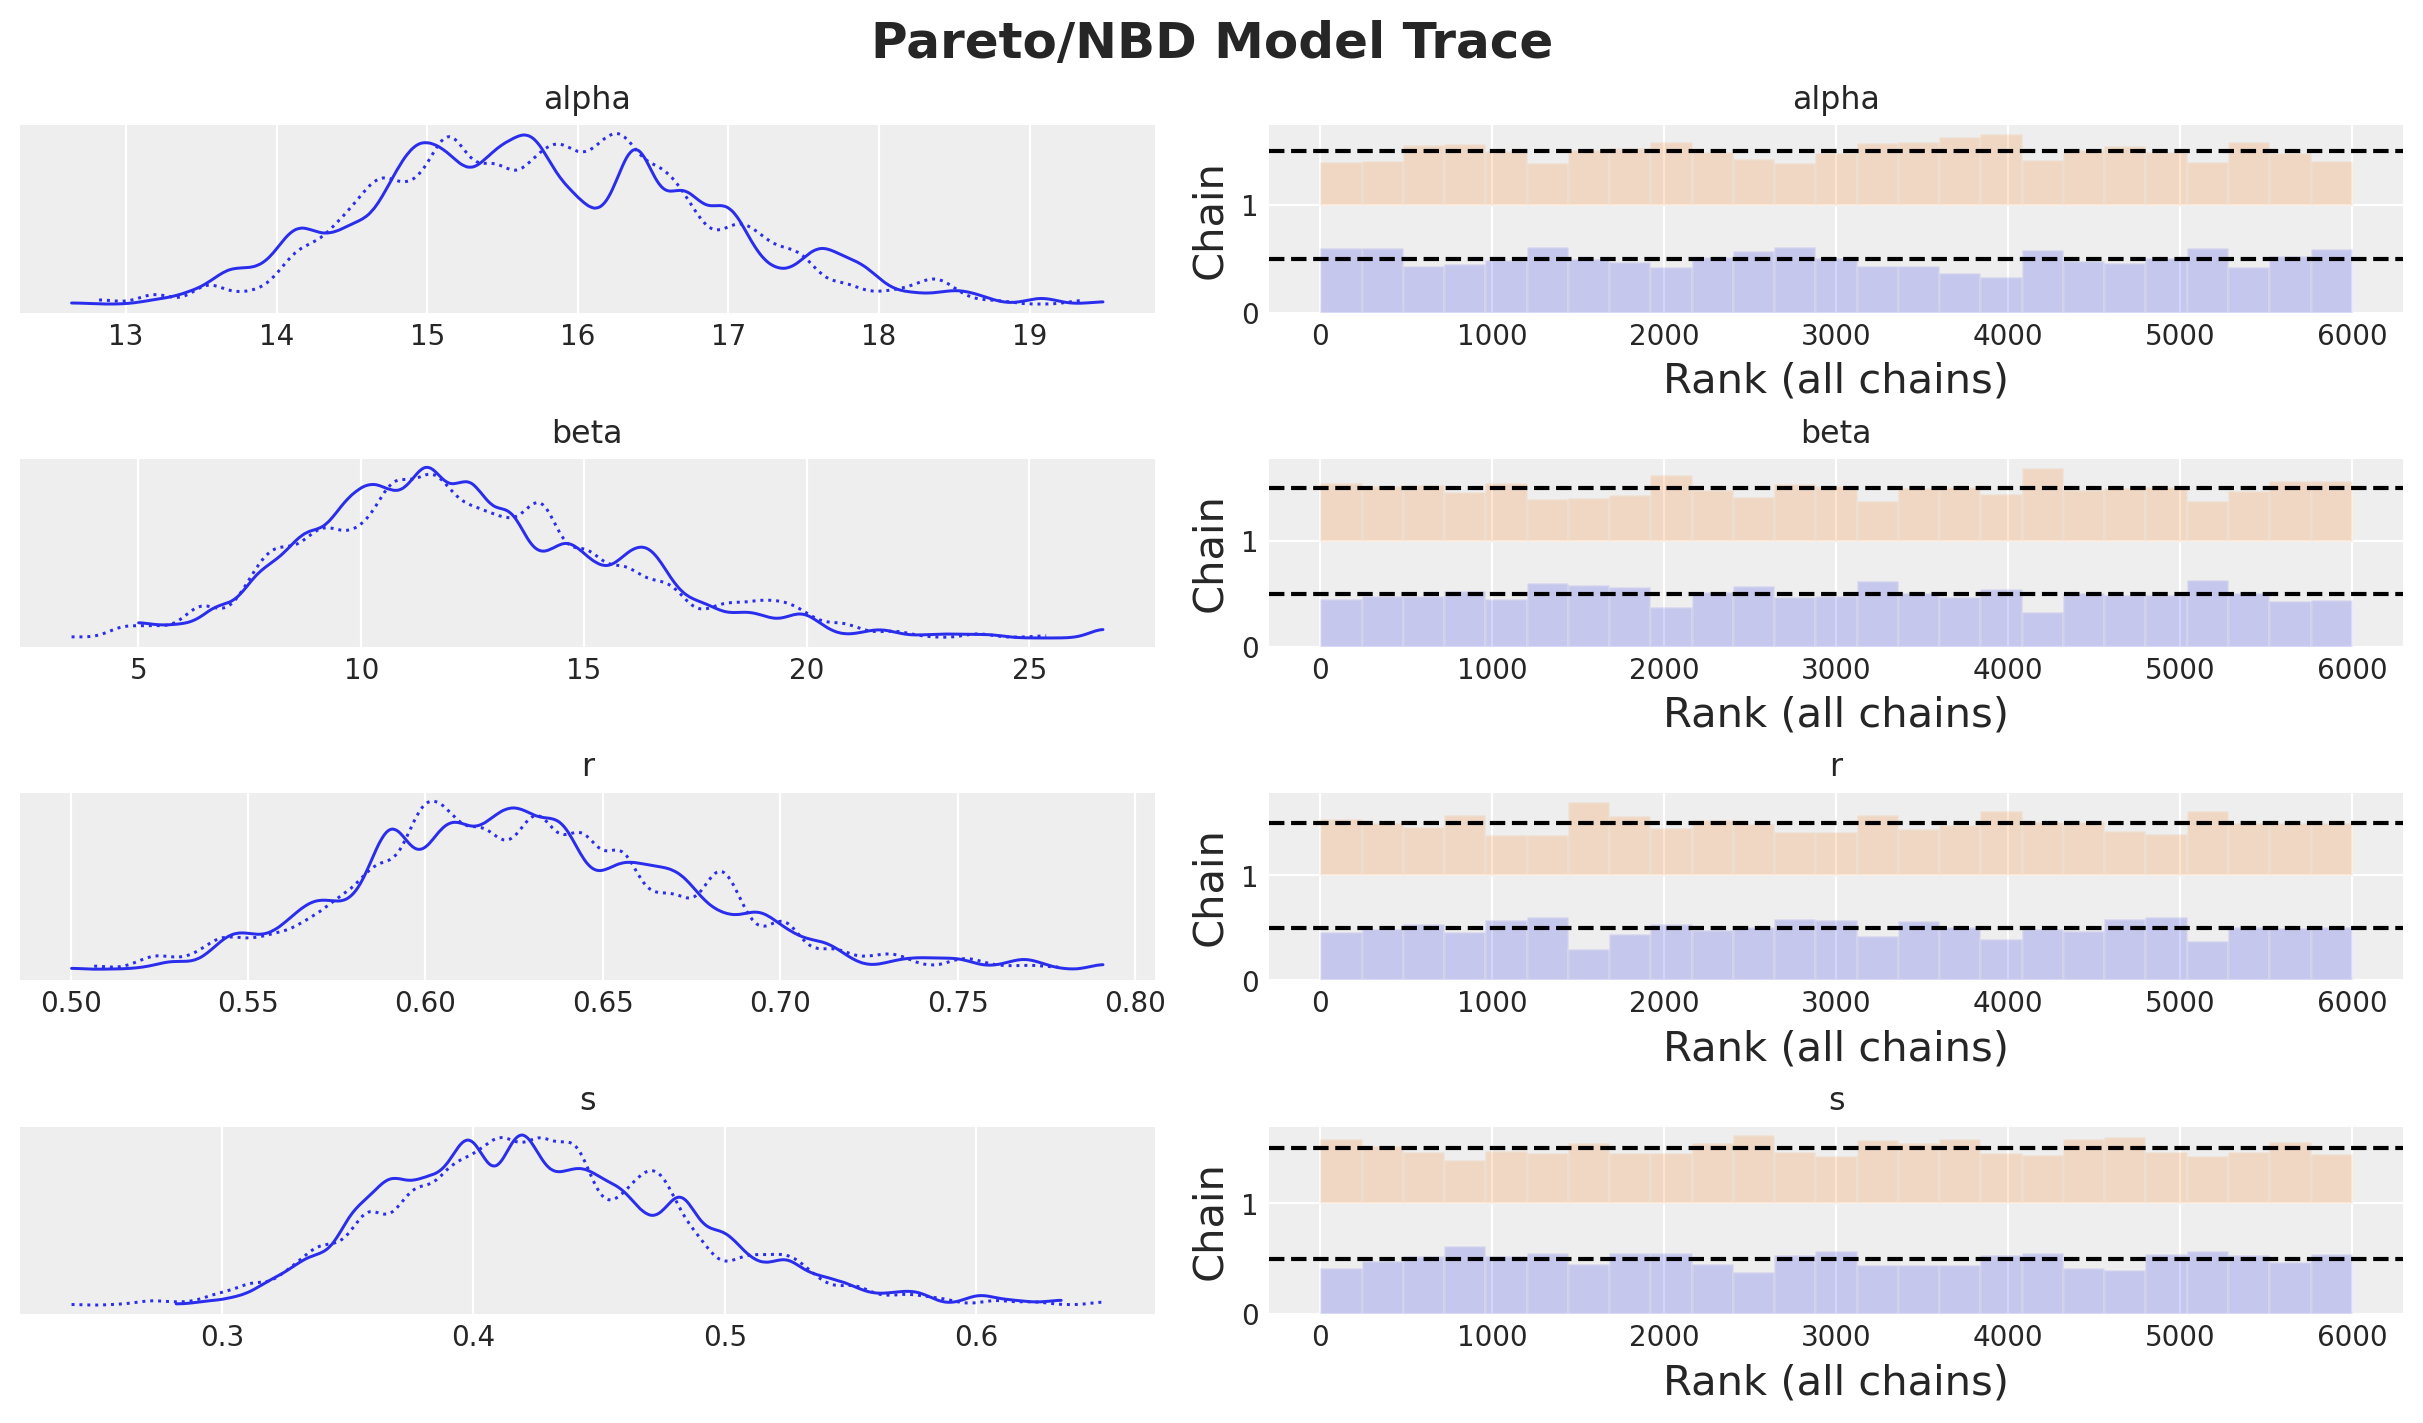

In [18]:
axes = az.plot_trace(
    data=pnbd_full.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Pareto/NBD Model Trace", fontsize=18, fontweight="bold");

In [19]:
pnbd_full.idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

Let's see how the DEMZ posteriors compare to the MAP estimations:

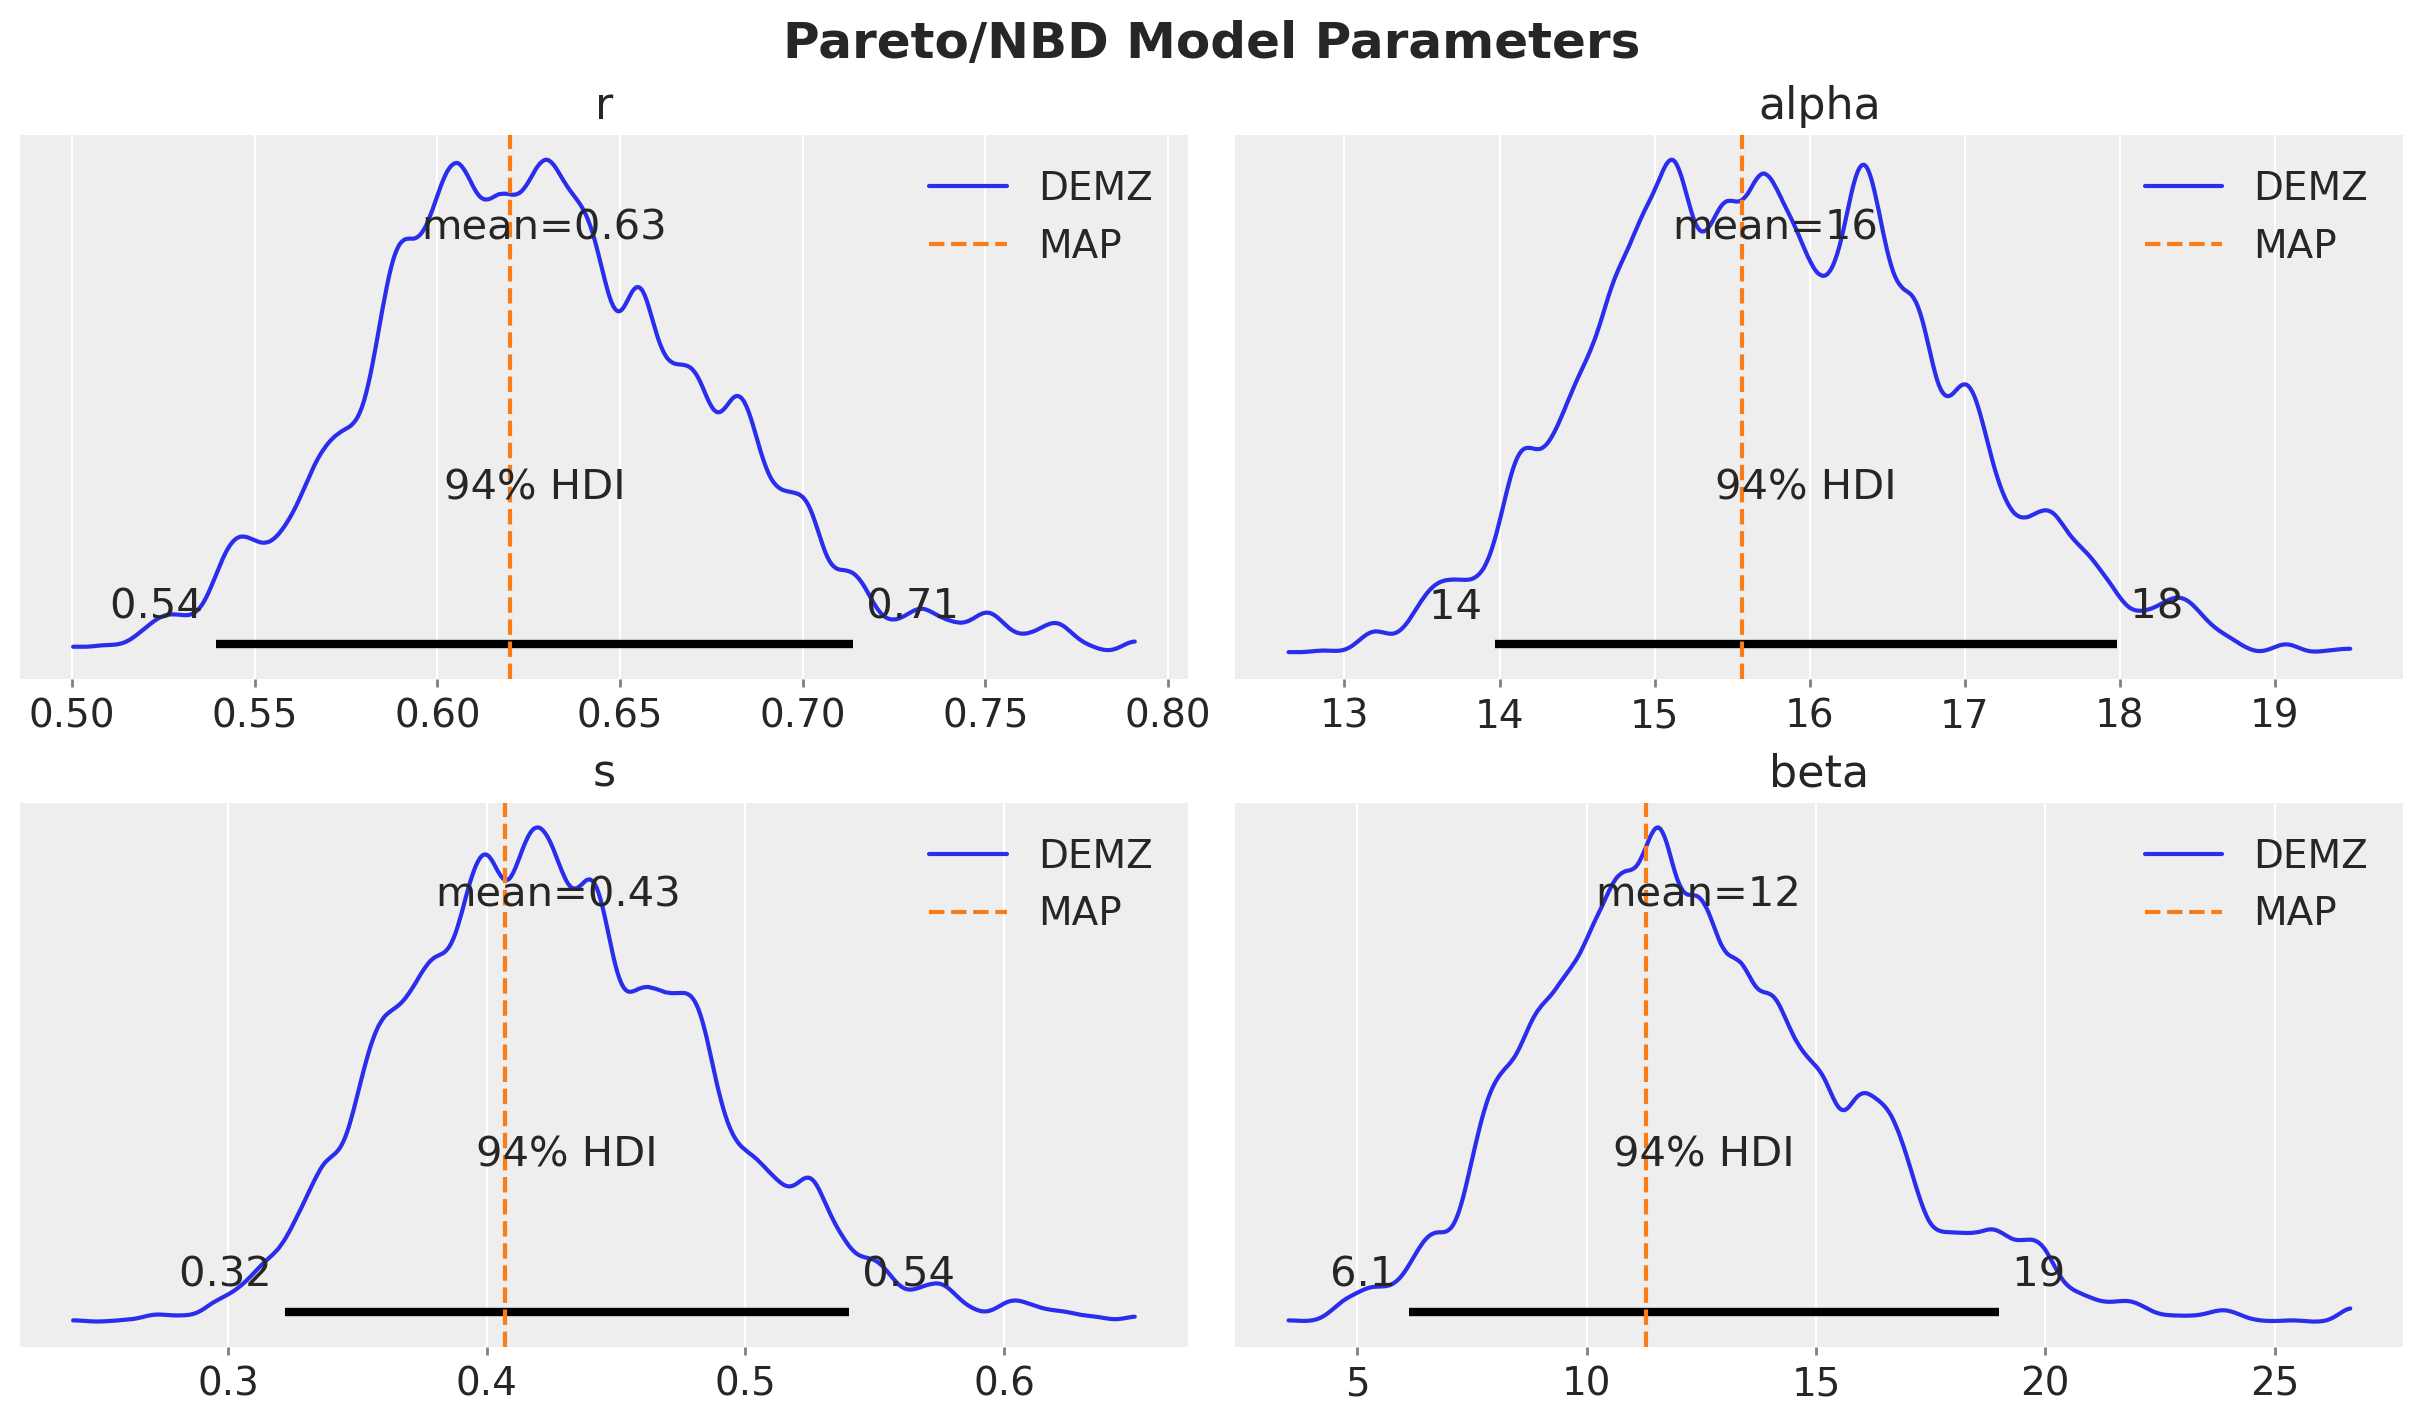

In [20]:
_, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 7), sharex=False, sharey=False, layout="constrained"
)

axes = axes.flatten()

for i, var_name in enumerate(["r", "alpha", "s", "beta"]):
    ax = axes[i]
    az.plot_posterior(
        pnbd_full.idata.posterior[var_name].values.flatten(),
        color="C0",
        point_estimate="mean",
        ax=ax,
        label="DEMZ",
    )
    ax.axvline(x=map_fit[var_name], color="C1", linestyle="--", label="MAP")
    ax.legend(loc="upper right")
    ax.set_title(var_name)

plt.gcf().suptitle("Pareto/NBD Model Parameters", fontsize=18, fontweight="bold");

After fitting, models can be persisted for later use:

In [21]:
pnbd_pymc.save("pnbd.nc")
pnbd_pymc.load("pnbd.nc")

/home/wdean/micromamba/envs/pymc-marketing-dev/lib/python3.10/site-packages/arviz/data/inference_data.py:157: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(


Pareto/NBD
            alpha ~ HalfFlat()
             beta ~ HalfFlat()
                r ~ HalfFlat()
                s ~ HalfFlat()
recency_frequency ~ ParetoNBD(r, alpha, s, beta, <constant>)

## Predictive Methods

The Pareto/NBD model supports a variety of predictive methods:

- `expected_purchases`
- `expected_probability_alive`
- `expected_purchases_new_customer`
- `expected_purchase_probability`

Let's take a small sample of users:

In [22]:
example_customer_ids = [1, 5, 10, 18, 46, 1413]

rfm_sample = rfm_data.query("customer_id.isin(@example_customer_ids)")

rfm_sample.sort_values(by="frequency")

,customer_id,frequency,recency,T
4,5,0.0,0.0,78.0
9,10,0.0,0.0,78.0
17,18,1.0,5.0,78.0
0,1,3.0,49.0,78.0
1405,1413,19.0,54.0,71.0
45,46,21.0,73.0,78.0


Observe customers 5 & 10 are *non-repeat buyers*, whereas 1413 and 46 are *frequent buyers*.

### Expected Number of Purchases
Let's plot each customer's expected number of purchases over the next $90$ time periods:

In [23]:
time_periods = 90

expected_purchases_over_time = xr.concat(
    objs=[
        pnbd_full.expected_purchases(
            data=rfm_sample,
            future_t=t,
        )
        for t in progress_bar(range(time_periods))
    ],
    dim="t",
).transpose(..., "t")

/home/wdean/micromamba/envs/pymc-marketing-dev/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


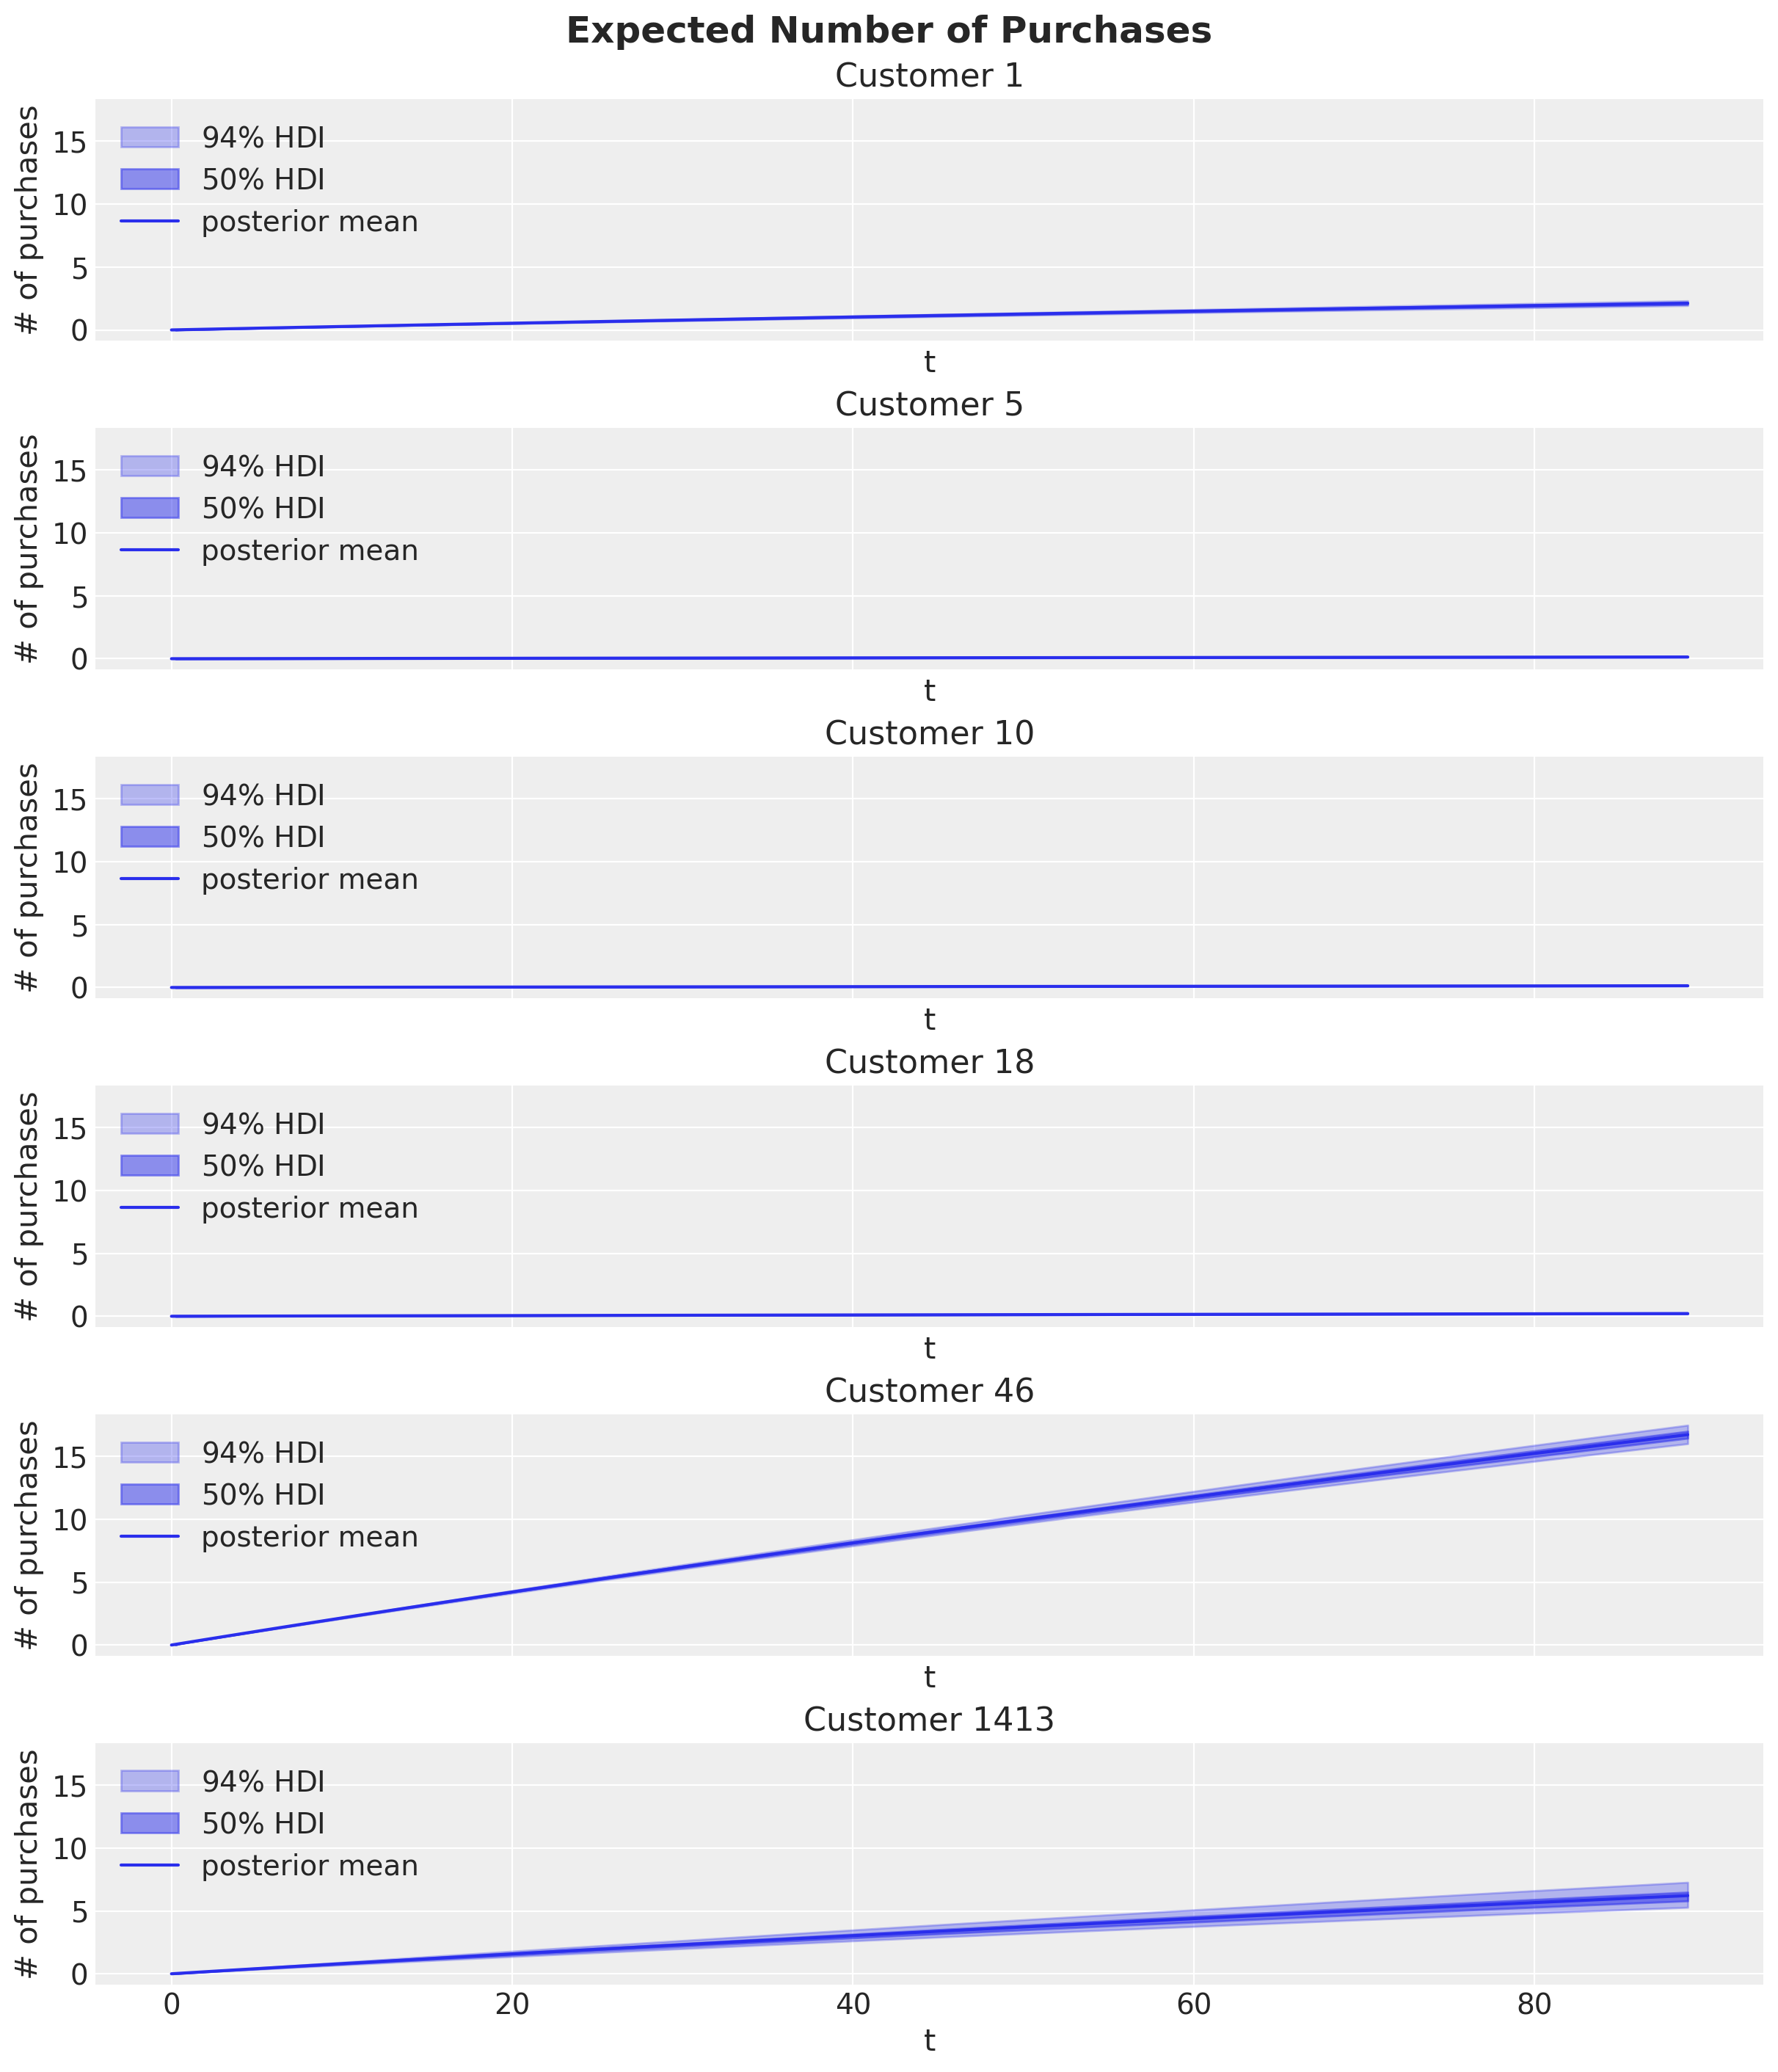

In [24]:
_, axes = plt.subplots(
    nrows=len(example_customer_ids),
    ncols=1,
    figsize=(12, 14),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.flatten()

for i, customer_id in enumerate(example_customer_ids):
    ax = axes[i]
    customer_expected_purchases = expected_purchases_over_time.sel(
        customer_id=customer_id
    )
    az.plot_hdi(
        range(time_periods),
        customer_expected_purchases,
        hdi_prob=0.94,
        color="C0",
        fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
        ax=ax,
    )
    az.plot_hdi(
        range(time_periods),
        customer_expected_purchases,
        hdi_prob=0.5,
        color="C0",
        fill_kwargs={"alpha": 0.5, "label": "$50 \\%$ HDI"},
        ax=ax,
    )
    ax.plot(
        range(time_periods),
        customer_expected_purchases.mean(dim=("chain", "draw")),
        color="C0",
        label="posterior mean",
    )
    ax.legend(loc="upper left")
    ax.set(title=f"Customer {customer_id}", xlabel="t", ylabel="# of purchases")

axes[-1].set(xlabel="t")
plt.gcf().suptitle("Expected Number of Purchases", fontsize=18, fontweight="bold");

Note the HDI prediction intervals are only available if the model is fit with full posteriors.

Observe the large number of purchases expected from the frequent buyers (Customers 46 and 1413) whereas little or no future activity is expected of the remaining customers.

### Expected Probability Alive
Let's check the probability our customers are still alive and compare against the MAP results.

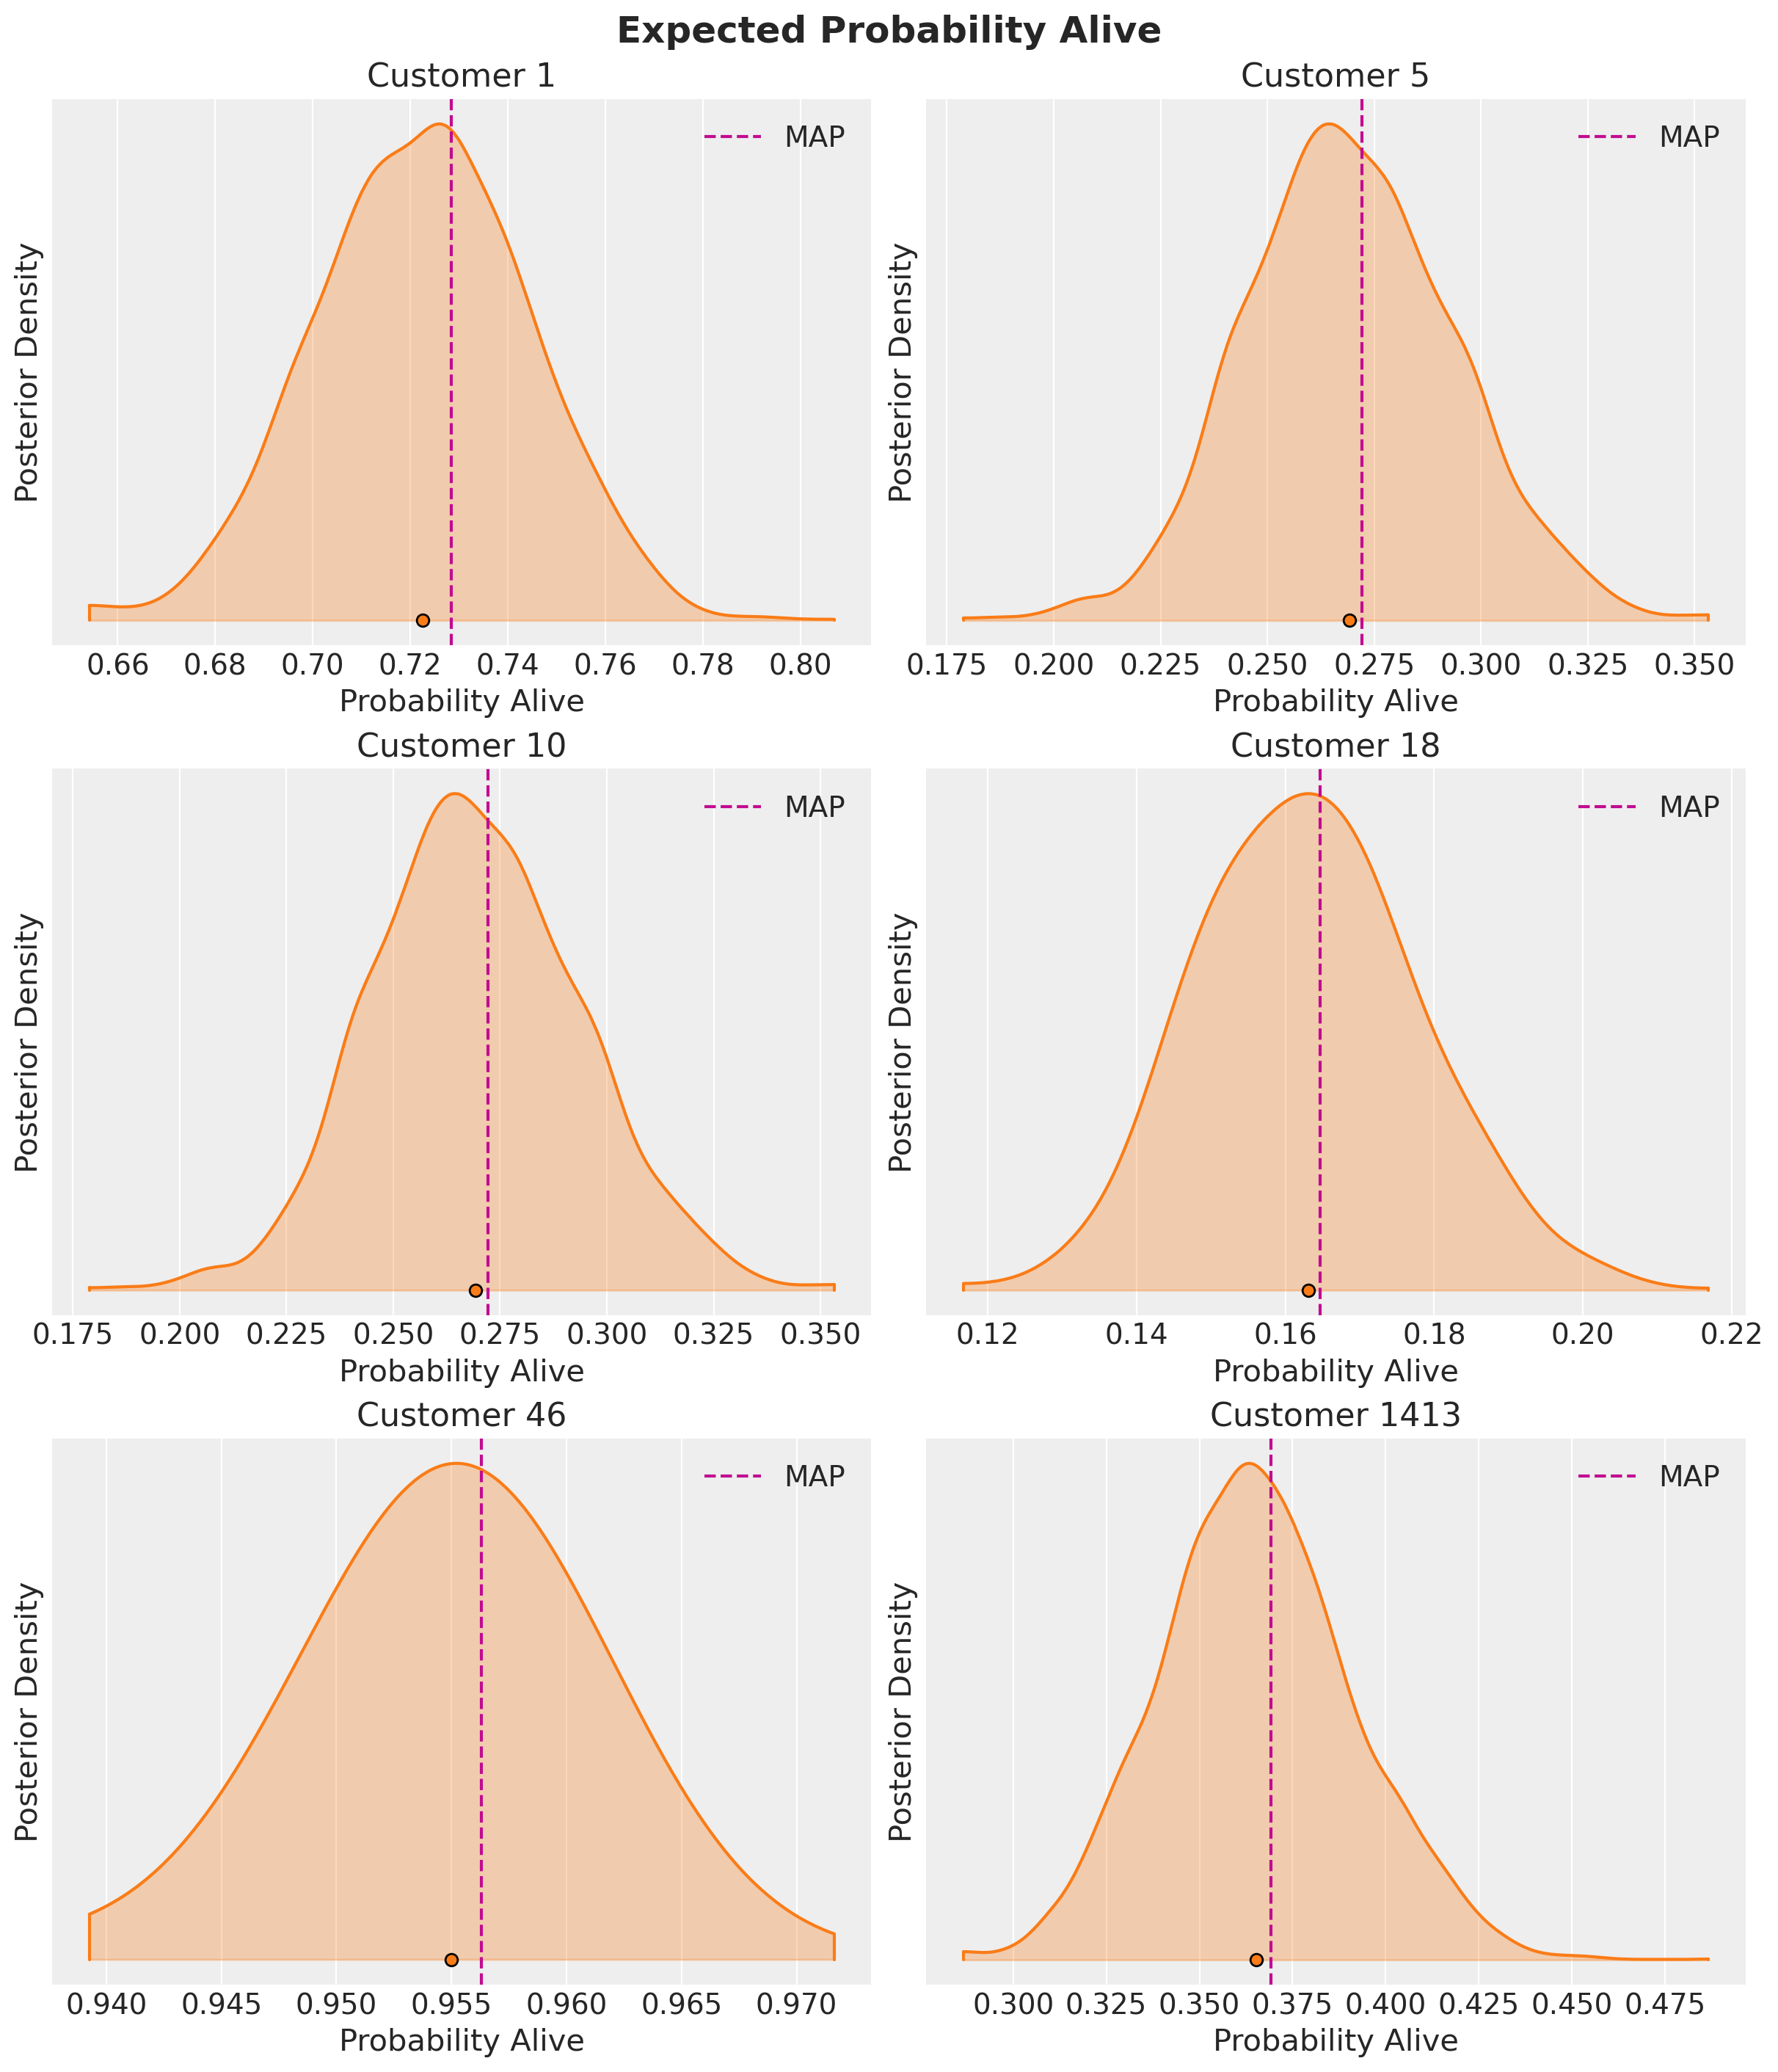

In [25]:
_, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(12, 14),
    layout="constrained",
)

axes = axes.flatten()

for i, customer_id in enumerate(example_customer_ids):
    ax = axes[i]
    demz_alive = pnbd_full.expected_probability_alive(
        rfm_sample,
        future_t=0,
    ).sel(customer_id=customer_id)
    map_alive = pnbd_map.expected_probability_alive(rfm_sample, future_t=0).sel(
        customer_id=customer_id
    )

    az.plot_density(demz_alive, hdi_prob=1, colors="C1", shade=0.3, bw=0.005, ax=ax)
    ax.axvline(x=map_alive, color="C3", linestyle="--", label="MAP")
    ax.legend(loc="upper right")
    ax.set(
        title=f"Customer {customer_id}",
        xlabel="Probability Alive",
        ylabel="Posterior Density",
    )

plt.gcf().suptitle("Expected Probability Alive", fontsize=18, fontweight="bold");

Customer 1413 has a rather low alive probability despite being a frequent purchaser. This would be a good example of a customer to target with a special offer for retention.

These probabilities are estimated at time period 0, but we can also estimate the probabilities customers will still be active in the future. Let's calculate the posterior densities 90 time periods from now and compare to the MAP at time period 0:

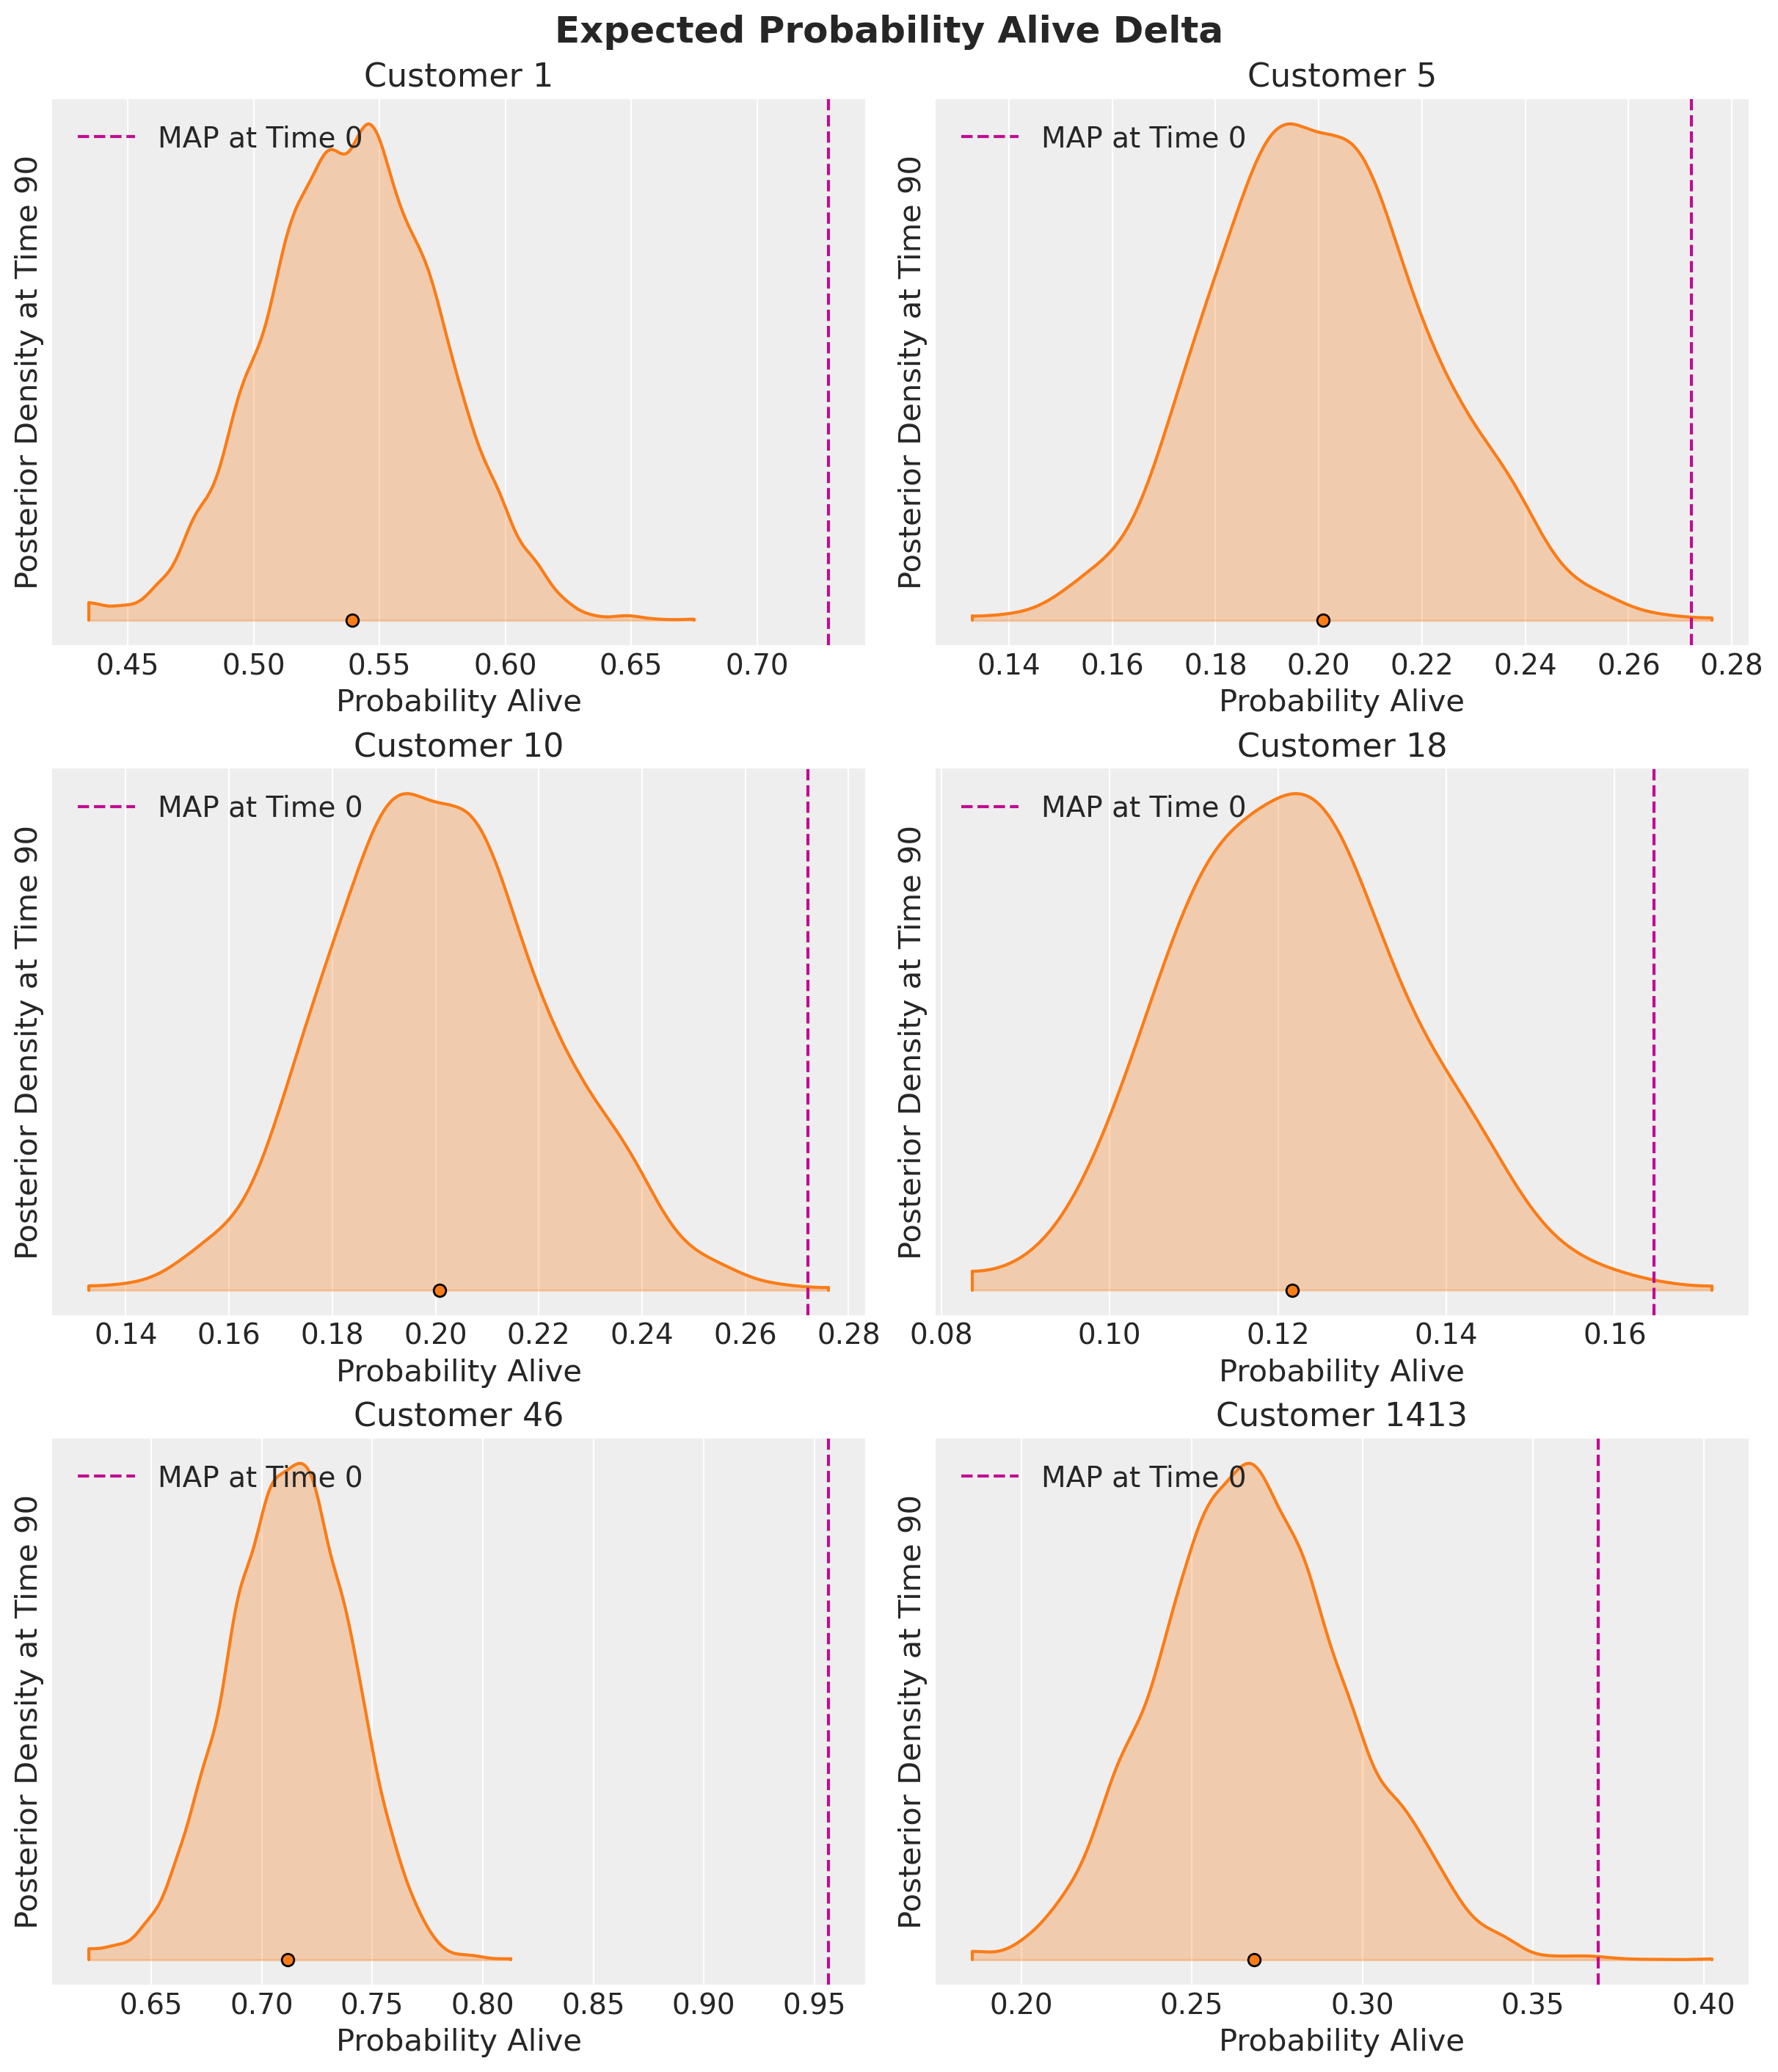

In [26]:
_, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(12, 14),
    layout="constrained",
)

axes = axes.flatten()

for i, customer_id in enumerate(example_customer_ids):
    ax = axes[i]
    demz_alive = pnbd_full.expected_probability_alive(
        rfm_sample,
        future_t=90,
    ).sel(customer_id=customer_id)
    map_alive = pnbd_map.expected_probability_alive(rfm_sample, future_t=0).sel(
        customer_id=customer_id
    )

    az.plot_density(demz_alive, hdi_prob=1, colors="C1", shade=0.3, bw=0.005, ax=ax)
    ax.axvline(x=map_alive, color="C3", linestyle="--", label="MAP at Time 0")
    ax.legend(loc="upper left")
    ax.set(
        title=f"Customer {customer_id}",
        xlabel="Probability Alive",
        ylabel="Posterior Density at Time 90",
    )

plt.gcf().suptitle("Expected Probability Alive Delta", fontsize=18, fontweight="bold");

Pay attention to the x-axes for each customer - The probabilities barely changed for the *non-repeat* customers, but there is a significant delta for *frequent buyers*.

A good rule of thumb is that an alive probability of .25-.30 usually indicates an at-risk or inactive customer. Future projections can give additional insight into customer churn risk.

### Probability of $n$ Purchases over Time $t$

Customer 46 is our best customer in this small sample set, and is expected to make at least $15$ purchases over the next $90$ time periods. What is the probability of this many purchases being made, and how will it change over time?

Let's plot a heatmap to paint the full picture:

In [27]:
# create arrays of parameter combinations
n_purchases = np.repeat([0, 3, 6, 9, 12, 15], 6)
time_periods = np.tile([15, 30, 45, 60, 75, 90], 6)

expected_purchase_prob_heatmap = xr.concat(
    objs=[
        pnbd_map.expected_purchase_probability(
            rfm_sample,
            n_purchases=params[0],
            future_t=params[1],
        ).sel(customer_id=46)
        for params in zip(n_purchases, time_periods, strict=False)
    ],
    dim="customer_id",
).transpose(..., "customer_id")

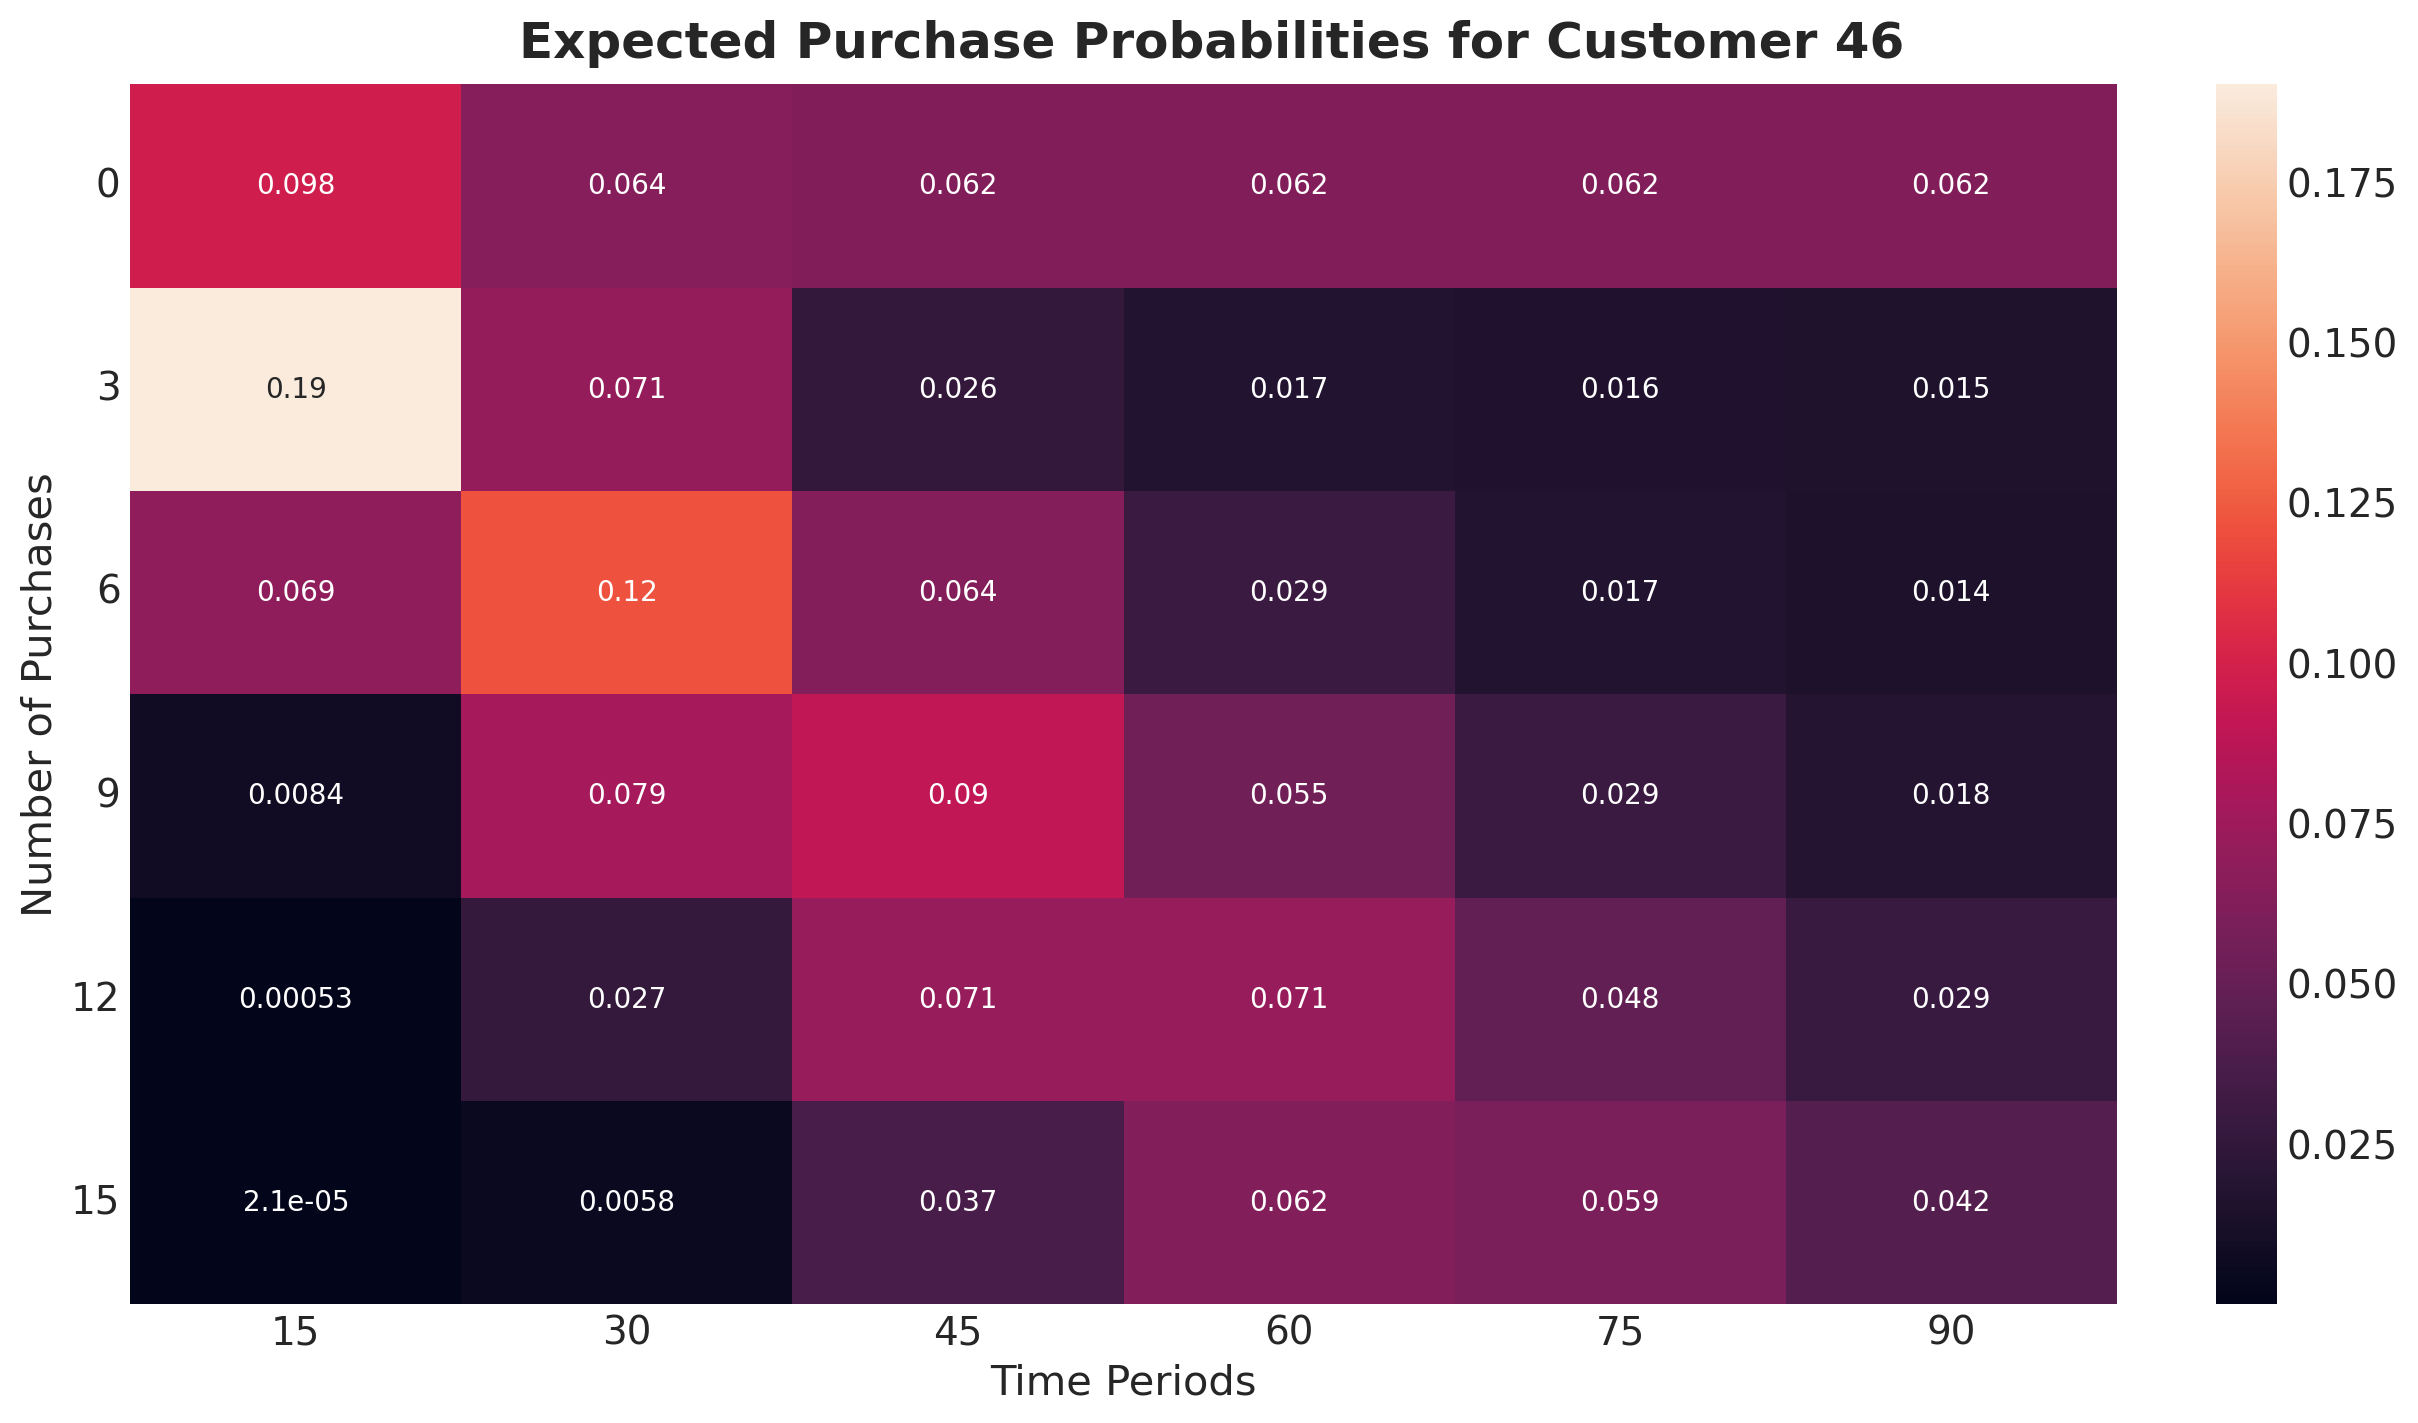

In [28]:
heatmap_reshape = expected_purchase_prob_heatmap.values.reshape(6, 6)

sb.heatmap(heatmap_reshape, annot=True)

plt.xlabel("Time Periods")
plt.xticks(np.arange(6) + 0.5, [15, 30, 45, 60, 75, 90], rotation=0)
plt.ylabel("Number of Purchases")
plt.yticks(np.arange(6) + 0.5, [0, 3, 6, 9, 12, 15], rotation=0)
plt.gcf().suptitle(
    "Expected Purchase Probabilities for Customer 46", fontsize=18, fontweight="bold"
);

This heatmap highlights how Customer 46 is expected to make at least 15 purchases *up to* time period 90, but the odds of 15 purchases being made before time period 75 or even time period 60 are slightly higher. Also note these probabilities assume exact expectations (i.e., there's a 6.2% chance of the 15th purchase being made precisely during time period 60.)

### Expected Number of Purchases for New Customers
So far we've only been running predictions for existing customers, but we can also estimate the expected number of transactions over time for a new customer:

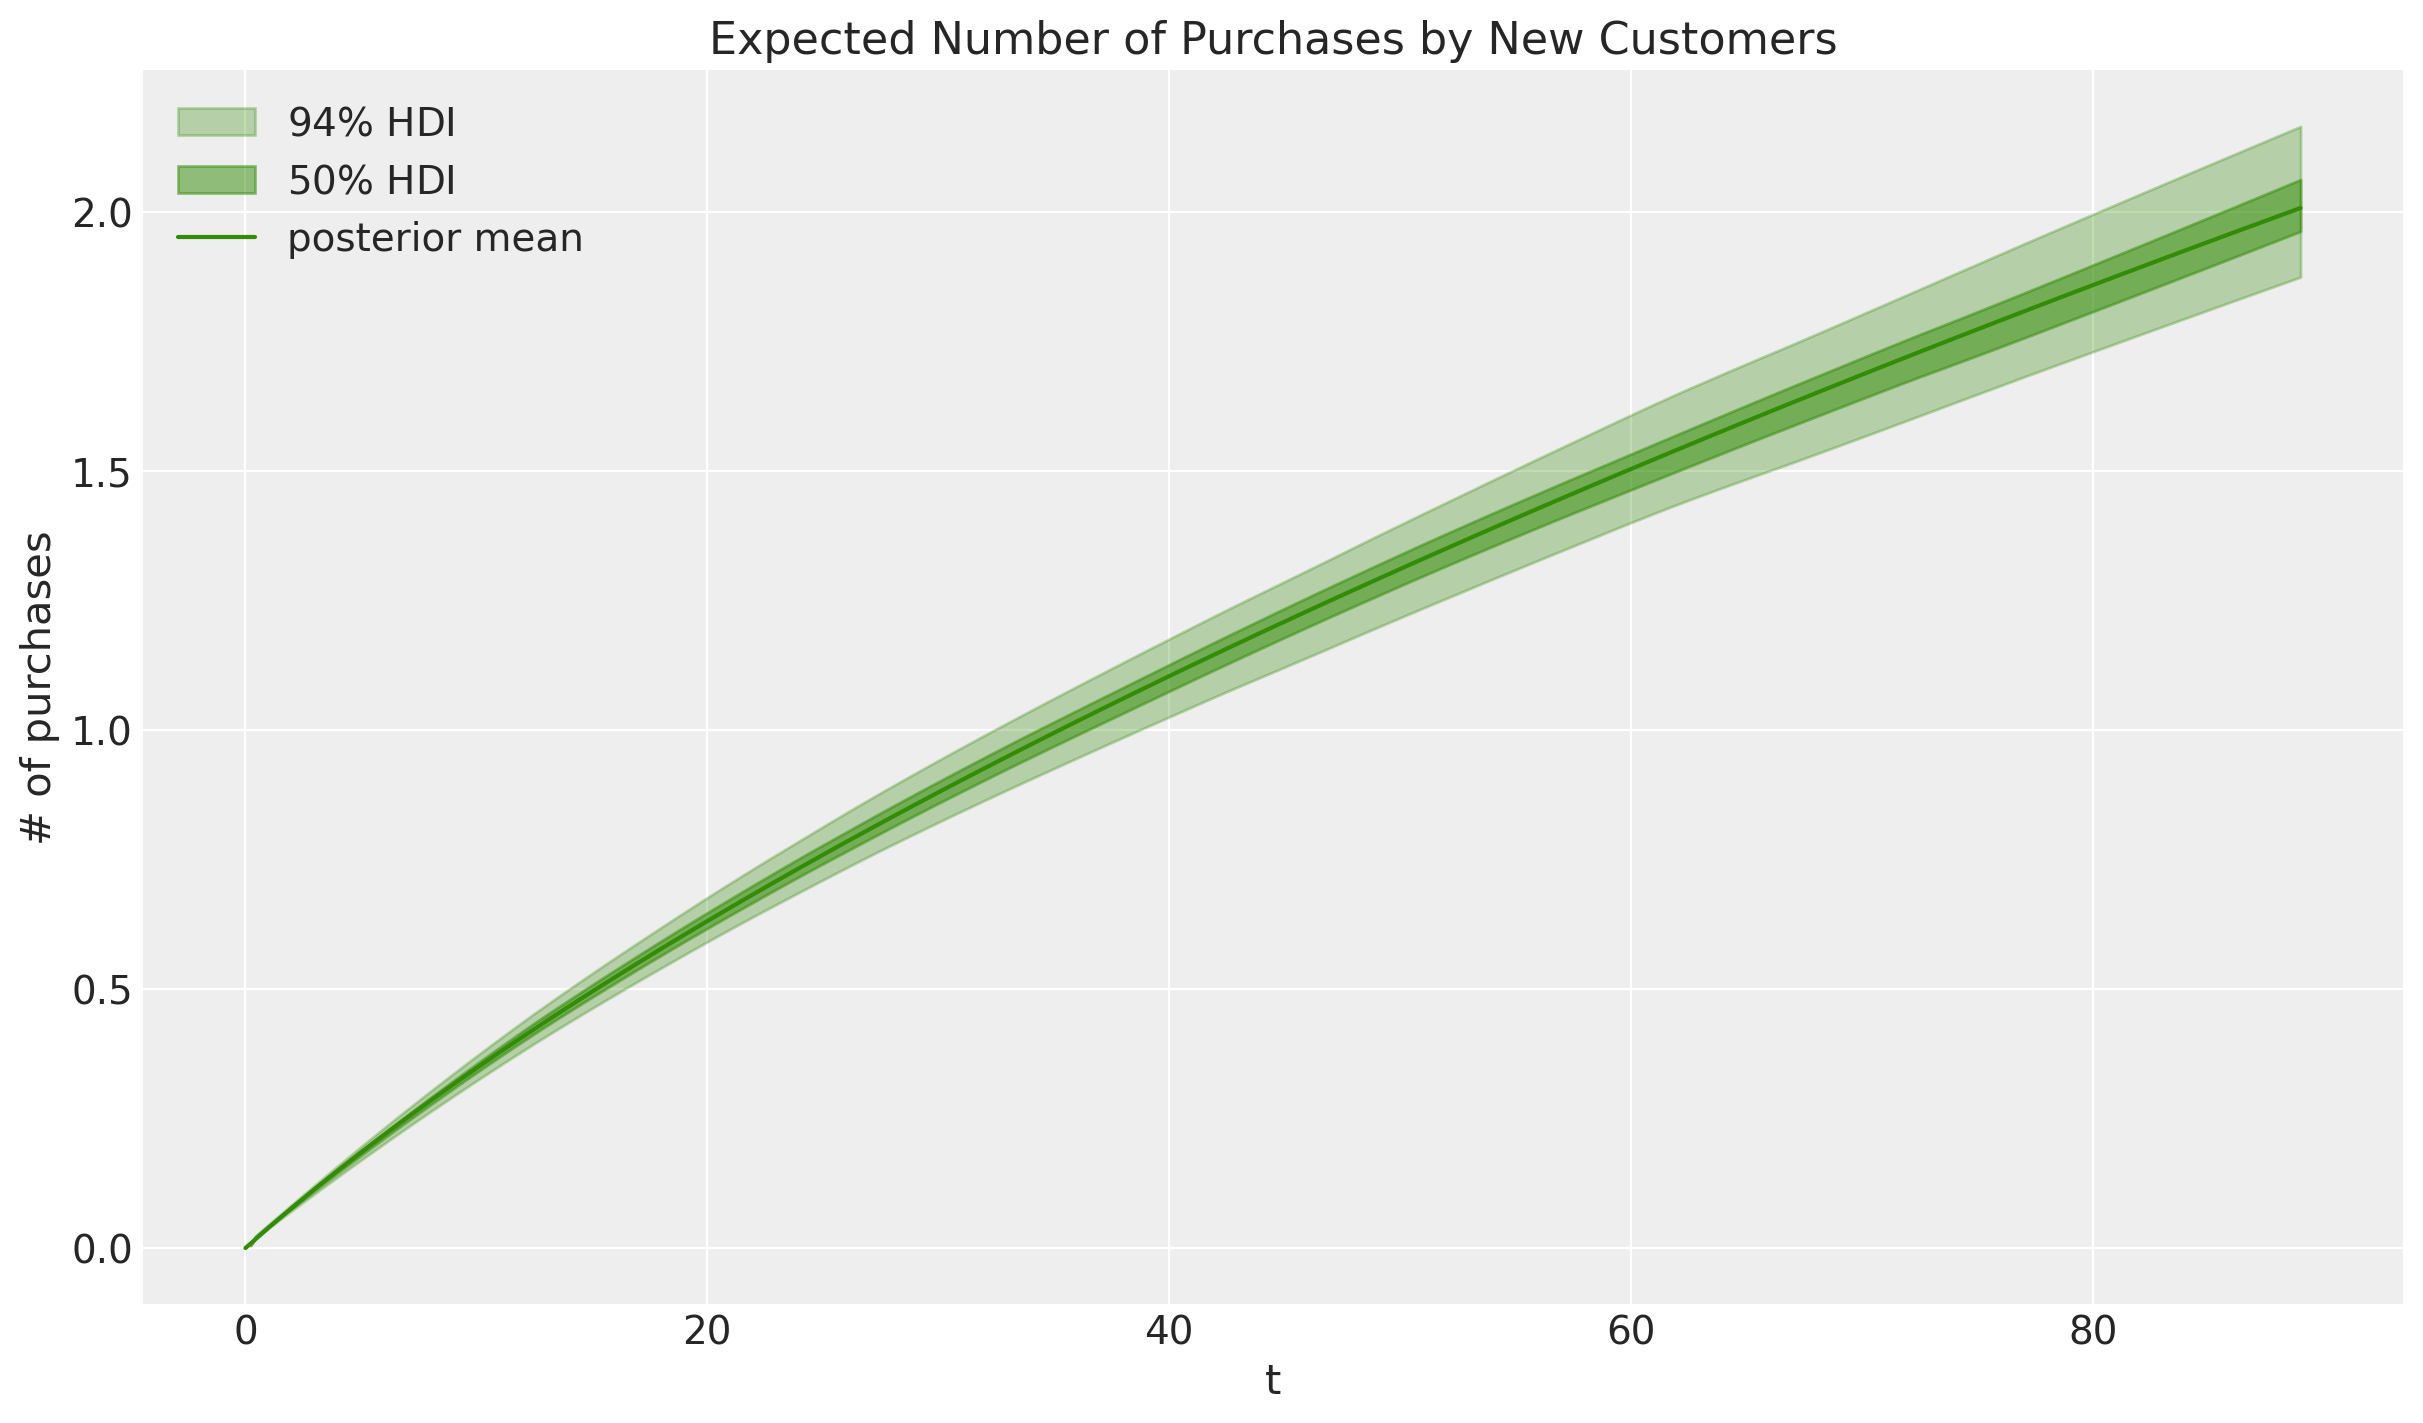

In [29]:
expected_purchases_over_time_new_customer = xr.concat(
    objs=[
        pnbd_full.expected_purchases_new_customer(
            data=rfm_sample,
            t=t,
        ).sel(customer_id=1)  # customer_id is arbitrary here
        for t in range(90)
    ],
    dim="t",
).transpose(..., "t")


# plot results
ax = plt.axes()

az.plot_hdi(
    range(90),
    expected_purchases_over_time_new_customer,
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    range(90),
    expected_purchases_over_time_new_customer,
    hdi_prob=0.5,
    color="C2",
    fill_kwargs={"alpha": 0.5, "label": "$50 \\%$ HDI"},
    ax=ax,
)
ax.plot(
    range(90),
    expected_purchases_over_time_new_customer.mean(dim=("chain", "draw")),
    color="C2",
    label="posterior mean",
)
ax.legend(loc="upper left")
ax.set(
    title="Expected Number of Purchases by New Customers",
    ylabel="# of purchases",
    xlabel="t",
);

Let's see how these estimates change when we add covariates to the model.

## Time-Invariant Covariates

Recall $\alpha$, and $\beta$ represent the scale parameters for the purchase and dropout rate distributions, respectively. To model for time-invariant covariates, we simply modify these parameters as follows:

$$\alpha = \alpha_0e^{-\gamma_1'z_1}$$
$$\beta = \beta_0e^{-\gamma_2'z_2}$$

Where $\gamma_1$ and $\gamma_2$ are coefficients capturing the impact of the covariates, and $z_1$ and $z_2$ the covariate arrays for each customer.

Let's take a look at the covariates available in the raw data:

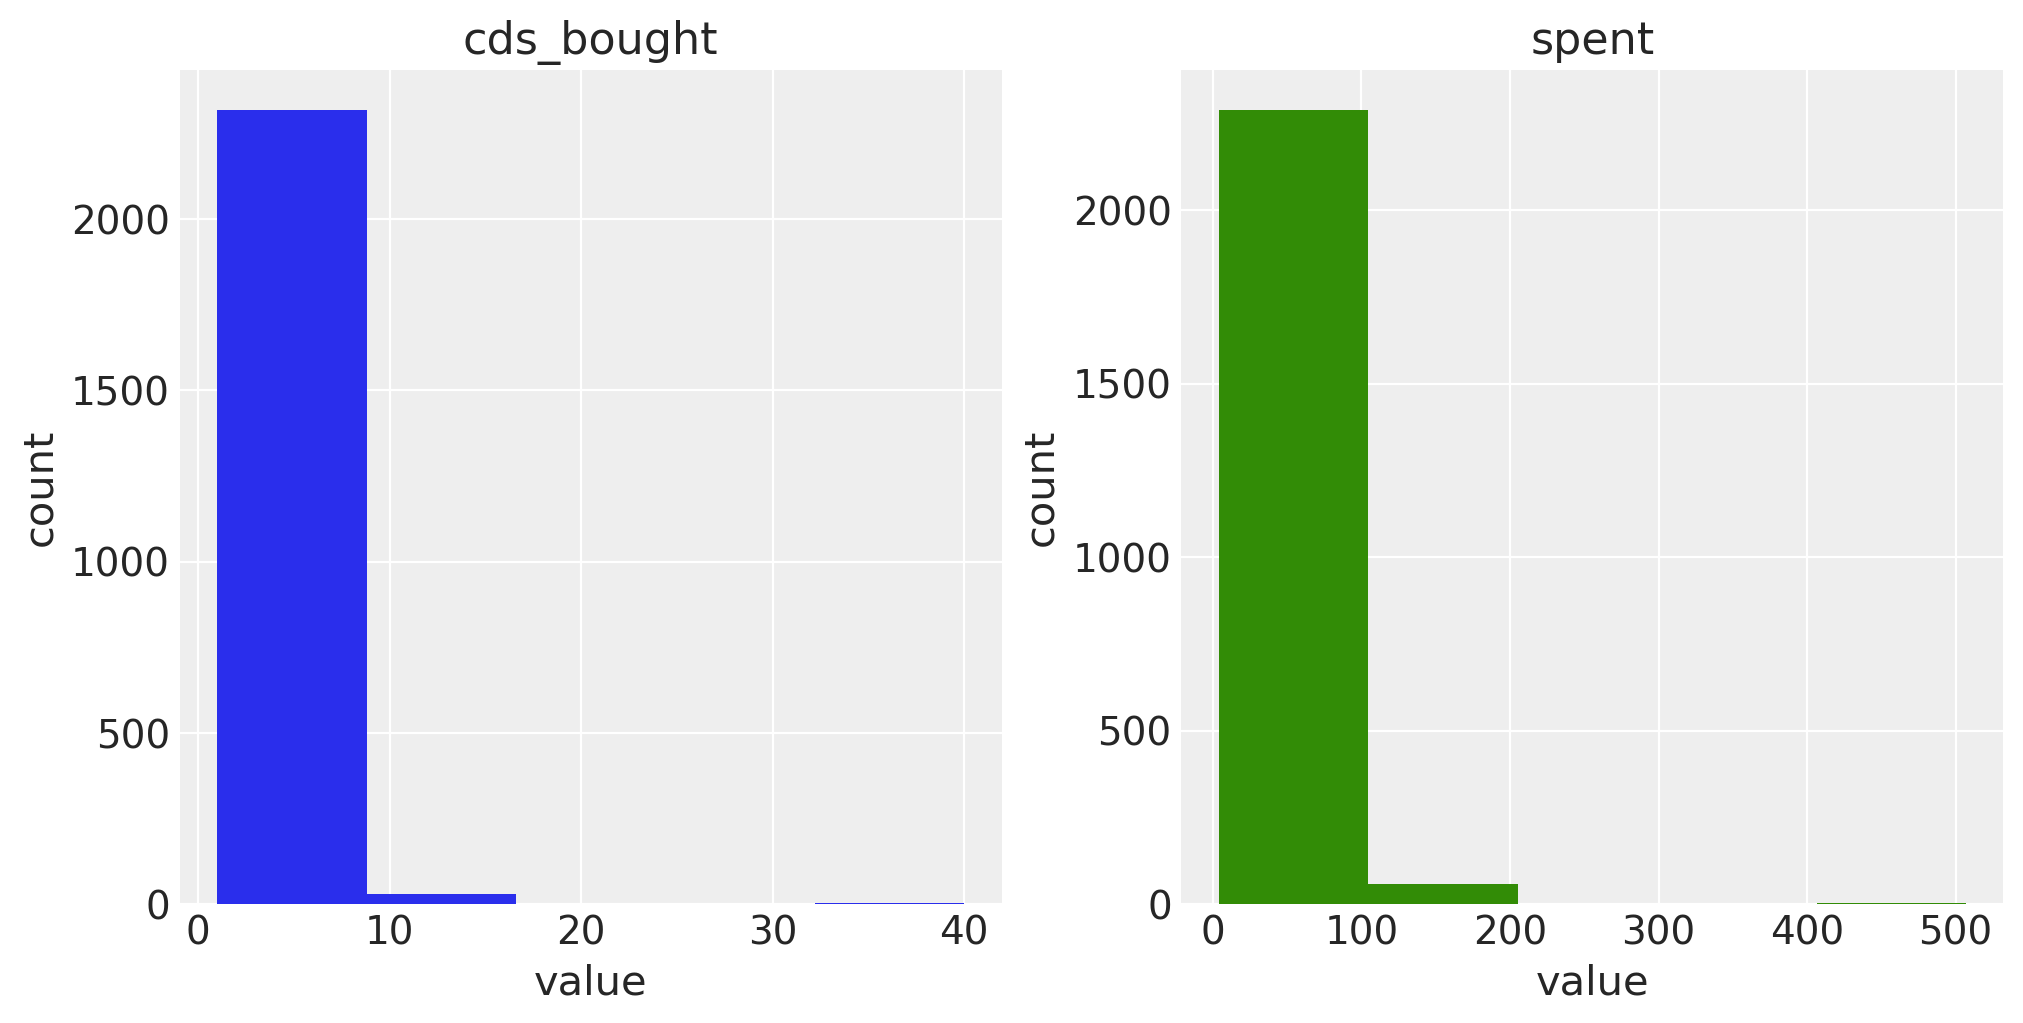

In [30]:
# aggregate raw data by customer id
covar_df = raw_data[["id", "cds_bought", "spent"]].groupby("id").mean().reset_index()

# plot covariate histograms
_, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 5),
    layout="constrained",
)

axes = axes.flatten()

covars = ["cds_bought", "spent"]
colors = ["C0", "C2"]

for ax in zip(axes, covars, colors, strict=False):
    ax[0].hist(
        x=covar_df[ax[1]],
        bins=5,
        color=ax[2],
    )
    ax[0].set(title=f"{ax[1]}", xlabel="value", ylabel="count")

One-tailed distributions with large values like this will complicate model fitting, so let's log and standardize our covariates:

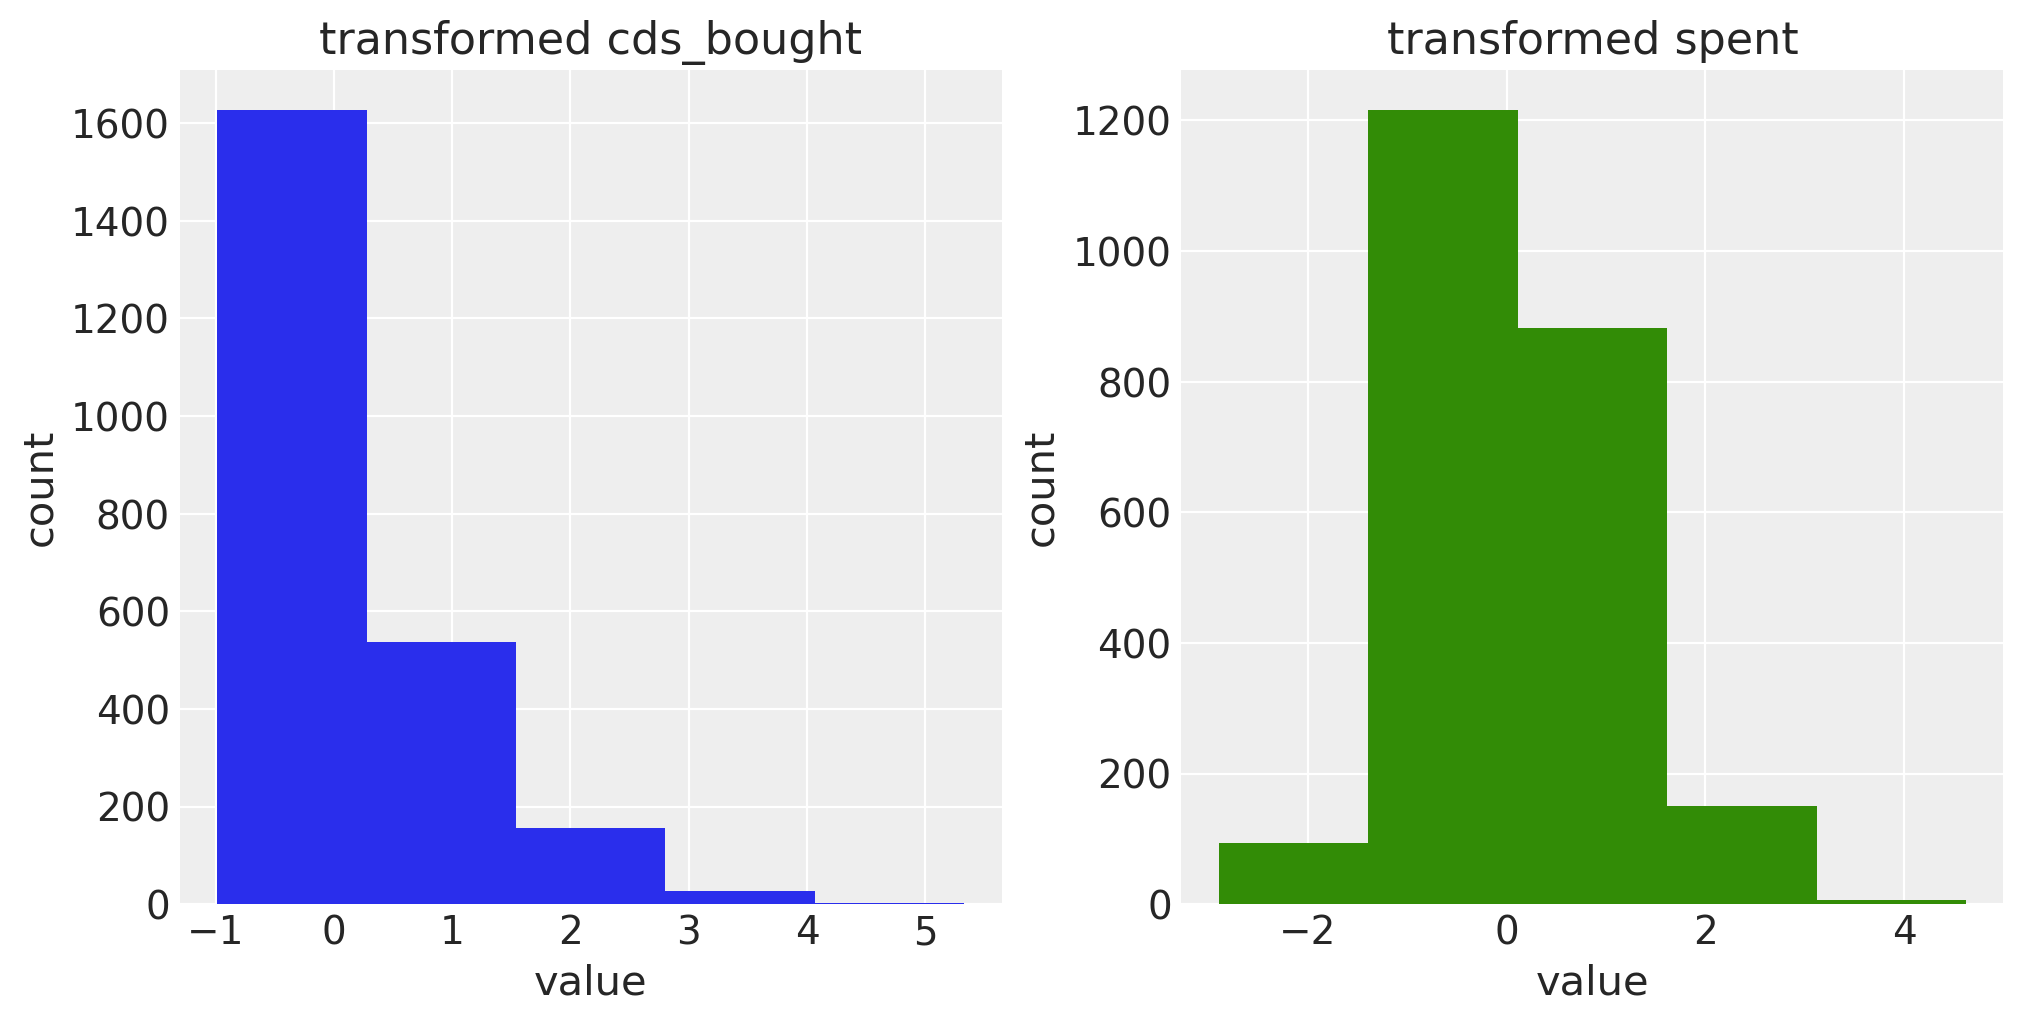

In [31]:
for covar in ["cds_bought", "spent"]:
    covar_df[f"log_std_{covar}"] = np.log(covar_df[covar]).copy()
    covar_df[f"log_std_{covar}"] -= np.nanmean(covar_df[f"log_std_{covar}"])
    covar_df[f"log_std_{covar}"] /= np.nanstd(covar_df[f"log_std_{covar}"])
    covar_df[f"log_std_{covar}"] = covar_df[f"log_std_{covar}"].fillna(0)

_, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 5),
    layout="constrained",
)

axes = axes.flatten()

for ax in zip(axes, covars, colors, strict=False):
    ax[0].hist(
        x=covar_df[f"log_std_{ax[1]}"],
        bins=5,
        color=ax[2],
    )
    ax[0].set(title=f"transformed {ax[1]}", xlabel="value", ylabel="count")

To parametrize `ParetoNBDModel` with covariates, join the covariates to the existing RFM data and specify the column names in the `model_config`. Covariates for the purchase and dropout rates can be specified separately, enabling experimentation with various combinations to find what works best:

In [32]:
rfm_covar = rfm_data.merge(covar_df, left_on="customer_id", right_on="id", how="inner")

pnbd_covar = clv.ParetoNBDModel(
    rfm_covar,
    model_config={
        "purchase_covariate_cols": ["log_std_cds_bought", "log_std_spent"],
        "dropout_covariate_cols": ["log_std_cds_bought", "log_std_spent"],
    },
)

pnbd_covar.build_model()
pnbd_covar

Pareto/NBD
purchase_coefficient ~ Normal(0, 1)
         alpha_scale ~ Weibull(2, 10)
 dropout_coefficient ~ Normal(0, 1)
          beta_scale ~ Weibull(2, 10)
                   r ~ Weibull(2, 1)
                   s ~ Weibull(2, 1)
               alpha ~ Deterministic(f(alpha_scale, purchase_coefficient))
                beta ~ Deterministic(f(beta_scale, dropout_coefficient))
   recency_frequency ~ ParetoNBD(r, alpha, s, beta, <constant>)

The additional parameters are automatically created when covariates are added.

Let's do a quick MAP fit and check the results:

In [33]:
pnbd_covar.fit(fit_method="map")

print("Fitted Model Parameters")
summary = pnbd_covar.fit_summary(
    var_names=[
        "r",
        "alpha_scale",
        "s",
        "beta_scale",
        "purchase_coefficient",
        "dropout_coefficient",
    ]
)
print(summary)

Output()

Fitted Model Parameters
r                                            0.668
alpha_scale                                 17.245
s                                            0.469
beta_scale                                  13.446
purchase_coefficient[log_std_cds_bought]     0.062
purchase_coefficient[log_std_spent]          0.189
dropout_coefficient[log_std_cds_bought]     -0.954
dropout_coefficient[log_std_spent]           0.337
Name: value, dtype: float64


The `purchase_coefficient` and `dropout_coefficient` parameters indicate the respective impacts of each covariate - a negative sign can be interpreted as "less likely to make a purchase or drop out".

We can see the average number of CDs per purchase only has a small impact on the time between purchases, but a rather large impact on the dropout rate. Customers who frequently purchase multiple CDs are the least likely to dropout.

The average spend per purchase is significant for both purchasing and time until dropout, but note that  if using the [Gamma-Gamma model](https://www.pymc-marketing.io/en/stable/notebooks/clv/gamma_gamma.html) to estimate customer lifetime value per the [Quickstart](https://www.pymc-marketing.io/en/stable/notebooks/clv/clv_quickstart.html), then *average spend cannot be used as a covariate* because an important modeling assumption for the Gamma-Gamma model is that spend and frequency are uncorrelated.

In [34]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Mon Jul 01 2024

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.22.2

pymc    : 5.14.0
pytensor: 2.20.0

numpy         : 1.26.4
seaborn       : 0.13.2
pymc          : 5.14.0
matplotlib    : 3.8.3
arviz         : 0.17.1
pymc_marketing: 0.6.0
xarray        : 2024.2.0
pandas        : 2.2.1

Watermark: 2.4.3

